# Notebook to train the Hybrid ResNet-ViT & ViT

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id, clean_zone_identifier_files
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data, plot_guidance_losses, plot_average_attention_scores
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from models3D import ResnetFeatureExtractor, ResNetViT, pureViT, upsample_vit_attention
import json
import nibabel as nib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

#clean_zone_identifier_files("/home/diogommiranda/tese/")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-10 13:04:00.112418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-10 13:04:00.852795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


# Select which Model to use
Note:
- When using ResNet and Hybrid Models the input shape is (91, 109, 91)
- When using PureViT the input shape is padded to (96, 112, 96) to make it divisible by a patch size of (16,16,16)

In [2]:
USE_MODEL = "hybrid" # Choose model: "hybrid", "purevit"

if USE_MODEL == "hybrid":
    print("Using Hybrid model. \nExpected input shape is (91, 109, 91)")
    apply_padding = False
    EXPECTED_FINAL_VOLUME_SHAPE = (91, 109, 91)
    
elif USE_MODEL == "purevit":
    print("Using pure ViT model. \nExpected input shape is (96, 112, 96)")
    apply_padding = True
    EXPECTED_FINAL_VOLUME_SHAPE = (96, 112, 96)
else:
    raise ValueError("Invalid model choice. Use 'hybrid' or 'purevit'.")

Using Hybrid model. 
Expected input shape is (91, 109, 91)


In [3]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci_balanced" # Choose dataset: "smci_pmci_balanced", "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/train...
    Found 349 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.3496308922767639, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/test...
    Found 87 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])
Min: 0.11078770458698273, Max: 0.8640980124473572


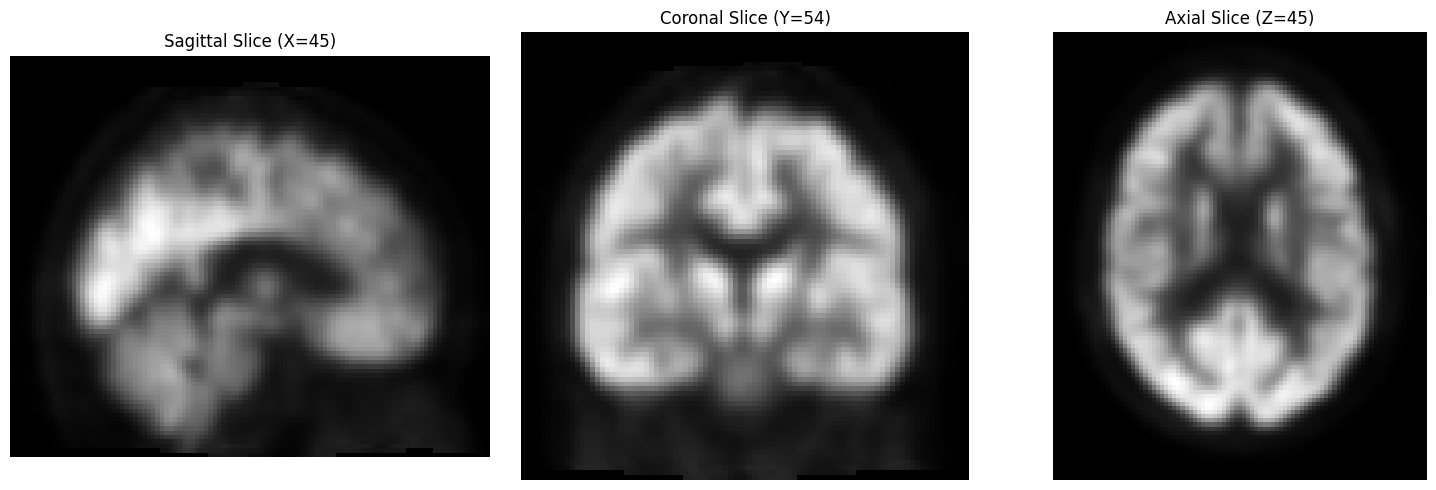

In [4]:
# Verify data with a test sample
i = 0
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    min_val = data[i].min().item()
    max_val = data[i].max().item()
    print(f"Min: {min_val}, Max: {max_val}")
    break

In [5]:
# Setting configurations for the best hybrid and pure ViT models

resnet_config = {
    'block': 'basic',
    'layers': [2, 2, 2, 2], # [2, 2, 2, 2] for ResNet18, [3, 4, 6, 3] for ResNet34
    'block_inplanes': [64, 128, 256, 512],
    'spatial_dims': 3,
    'n_input_channels': 1,
    'conv1_t_stride': 2,
    'num_classes': 1, 
    'shortcut_type': 'B',
    'bias_downsample': True
}

vit_config = {
    'in_channels': 256,
    'img_size': (6,7,6),
    'patch_size': (1,1,1),  
    'num_heads': 8,
    'hidden_size': 504,
    'mlp_dim': 2016,
    'num_layers': 7,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': True,
    'save_attn_logits': True
}

purevit_config = {
    'in_channels': 1,
    'img_size': (96,112,96),
    'patch_size': (16,16,16),
    'num_heads': 12,
    'hidden_size': 768,
    'mlp_dim': 3072,
    'num_layers': 12,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': True,
    'save_attn_logits': True
    }

# Get ROI mask and setup variables for the guidance loss

Mask volume shape: (1, 91, 109, 91)
Number of ROI voxels: 37384
Number of non-ROI voxels: 865245
Mask volume shape after adding batch dimension: torch.Size([1, 91, 109, 91])


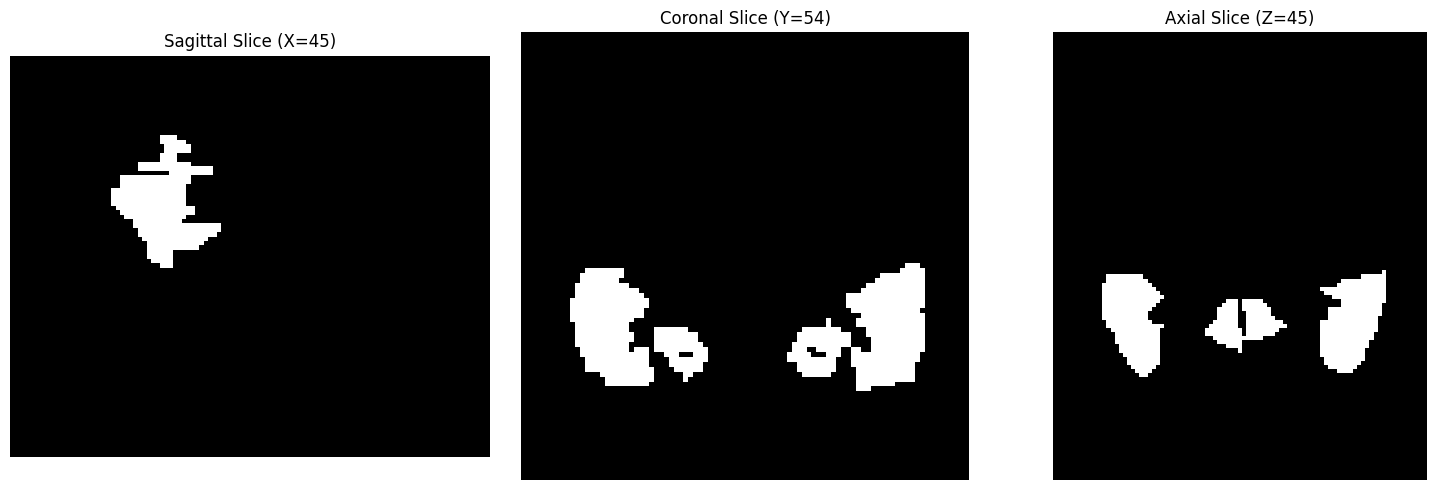

In [6]:
# Set up ROI mask to be used in the guidance loss function
mask_path = Path("/home/diogommiranda/tese/masks/ROI_MASK.nii")
mask_img = nib.load(mask_path)
mask_volume = mask_img.get_fdata(dtype=np.float32)
assert mask_volume.shape == (91, 109, 91), "Mask volume shape must be (91, 109, 91)"
if apply_padding:
    padding = (
        (2,3), # Pad width from 91 to 96
        (1,2), # Pad height from 109 to 112
        (2,3)  # Pad depth from 91 to 96
    )
    mask_volume = np.pad(mask_volume, padding, mode='edge')
    
mask_volume = np.expand_dims(mask_volume, axis=0)
mask_volume = np.transpose(mask_volume, (0, 3, 2, 1)) # Transpose to (depth, height, width)
print(f"Mask volume shape: {mask_volume.shape}")
mask_volume = torch.tensor(mask_volume, dtype=torch.float32)
view_image_data(mask_volume)

# Get number of ROI and non-ROI voxels in the mask - needed for the guidance loss function
roi_voxels = mask_volume[mask_volume == 1].numel()
print(f"Number of ROI voxels: {roi_voxels}")
non_roi_voxels = mask_volume[mask_volume == 0].numel()
print(f"Number of non-ROI voxels: {non_roi_voxels}")

mask_volume = mask_volume.to(device)
print(f"Mask volume shape after adding batch dimension: {mask_volume.shape}")



# Select guidance loss config parameters

In [7]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----
RETURN_ATTENTION = 'raw' # Choose attention type: 'softmaxed', 'raw', 'none'
LEVEL = 'image' # Choose level-space to apply guidance loss: 'image', 'token'
#LOSS_FUNCTION = 'kvl' # choose loss function: 'kvl', 'weighted_sum'

if RETURN_ATTENTION == 'softmaxed':
    print("Using softmaxed attention maps in the guidance loss.")
elif RETURN_ATTENTION == 'raw':
    print("Using raw logits attention maps in the guidance loss.")
else:
    raise ValueError("Invalid attention type. Use 'softmaxed' or 'raw' to retrieve the attention maps.")

if LEVEL == 'image':
    print("Using image-level guidance loss.")
    mask_volume.to(device) # Move mask volume to device
if LEVEL == 'token':
    # Interpolate the mask volume to match the 
    # add batch dimension
    mask_volume = mask_volume.unsqueeze(0) # Add batch dimension
    mask_volume = F.interpolate(
    input = mask_volume,
    mode = 'area',
    size = (6, 7, 6)
    )
    token_roi_scores = mask_volume.flatten(start_dim=1)
    token_roi_scores = token_roi_scores.to(device) # Move token ROI scores to device
elif LEVEL != 'image':
    raise ValueError("Invalid level-space. Use 'image' or 'token'.")

Using raw logits attention maps in the guidance loss.
Using image-level guidance loss.


# Nested Cross-Validation

In [22]:
# Base directory for layers and heads
if USE_MODEL == "hybrid":
    learning_rate = 2e-7
    weight_decay = 4e-3
    CLS_LAYER = 6
    NUM_EPOCHS = 100
    EARLY_STOP_PATIENCE = 20
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/roi_guidance/resnetvit/" + DATASET
elif USE_MODEL == "purevit":
    learning_rate = 5e-7
    weight_decay = 4e-3
    CLS_LAYER = 12
    NUM_EPOCHS = 1000
    EARLY_STOP_PATIENCE = NUM_EPOCHS
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/roi_guidance/purevit/" + DATASET
else:
    raise ValueError("Invalid model type. Choose 'hybrid' or 'purevit'.")
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)

lambda_factors = [1e-4]
#T = 0.01

N_SPLITS = 5

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()
            
# For-loop over determined learning rates and weight decays

for T in [0.1]: 
    for lambda_factor in lambda_factors:
        print("=" * 60)
        print(f"Testing Combination: lambda={lambda_factor} for CLS_LAYER={CLS_LAYER} and {USE_MODEL} model")

        combo_dir_name = f"Layer_{CLS_LAYER}/T={T}/lambda_{lambda_factor}"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        if os.path.exists(combo_results_dir):
            print(f"\nDirectory {combo_results_dir} already exists. Skipping...\n")
            continue
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"    Saving results for this combo to: {combo_results_dir}")
        print("=" * 60)

        start_time_combination = time.time()
        
        current_combo_val_losses = []
        
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []
        
        current_combo_val_sensitivities = []
        current_combo_val_specificities = []
        current_combo_val_baccs = []
        current_combo_val_f1s = []
        current_combo_val_mccs = []

        current_combo_test_losses = []

        
        current_combo_test_accuracies = []
        current_combo_test_aucs = []
        
        current_combo_test_sensitivities = []
        current_combo_test_specificities = []
        current_combo_test_baccs = []
        current_combo_test_f1s = []
        current_combo_test_mccs = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            
            # Runs only desired fold and skips the rest: for testing purposes
            if fold_no > 1:
                continue
            
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                    raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding
            )
            
            test_data = create_dataloader(
                paths=test_paths,
                labels=test_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False,
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding
                )

            if fold_train_data is None or fold_val_data is None or test_data is None:
                    raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            if USE_MODEL == "hybrid":
                resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config)
                model = ResNetViT(resnet_feature_extractor, vit_config).to(device)
            elif USE_MODEL == "purevit":
                model = pureViT(purevit_config).to(device)
            else:
                raise ValueError("Invalid model type. Choose 'hybrid' or 'purevit'.")

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
            best_val_loss = float('inf')
            best_val_bacc = -float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [],
                    'train_classification_loss': [], 'train_guidance_loss': [], 'train_penalization_term_loss': [], 'train_reward_term_loss':[], 'train_avg_att_roi': [], 'train_avg_att_non_roi': [],
                    'val_loss': [], 'val_accuracy': [], 'val_auc': [],
                    'val_classification_loss': [], 'val_guidance_loss': [], 'val_penalization_term_loss': [], 'val_reward_term_loss': [], 'val_avg_att_roi': [], 'val_avg_att_non_roi': [],
                    'val_sensitivity': [], 'val_specificity': [], 'val_bacc': [], 'val_f1': [], 'val_mcc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # ---------------- Train phase ----------------
                model.train()
                
                running_loss = 0.0
                
                running_classification_loss = 0.0
                running_guidance_loss = 0.0
                running_penalization_term_loss = 0.0
                running_reward_term_loss = 0.0
                
                running_avg_att_roi = 0.0
                running_avg_att_non_roi = 0.0
                
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs, attention_maps = model(inputs, return_attention=RETURN_ATTENTION)
                        classification_loss = criterion(outputs, labels)
                    
                        if USE_MODEL == "hybrid":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True)
                        elif USE_MODEL == "purevit":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later   
                        cls_attn = attn_map[:, 0, 1:] # Get CLS attention vector
                        
                        volume_att = upsample_vit_attention(cls_attn, EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map
                        volume_att = volume_att.flatten(start_dim=1) # first dimension is the batch size, which is 1
                        volume_att = F.softmax(volume_att / T, dim=-1)  # Apply softmax to the CLS attention vector
                        volume_att = volume_att.reshape(len(inputs), EXPECTED_FINAL_VOLUME_SHAPE[0], EXPECTED_FINAL_VOLUME_SHAPE[1], EXPECTED_FINAL_VOLUME_SHAPE[2])  # Reshape back to the original volume shape

                        penalization_term_loss = torch.mean(torch.sum(torch.multiply(torch.log(1-volume_att+1e-10), 1-mask_volume), dim=(1,2,3))) # penalization term of the guidance loss across the batch
                        reward_term_loss = torch.mean(torch.sum(torch.multiply(torch.log(volume_att+1e-10), mask_volume), dim=(1,2,3))) # reward term of the guidance loss across the batch
                        guidance_loss = - lambda_factor * (penalization_term_loss + reward_term_loss)
                    
                        loss = classification_loss + guidance_loss
                        
                        avg_att_roi = torch.mean(torch.sum(torch.multiply(volume_att, mask_volume), dim=(1,2,3)) / roi_voxels)
                        avg_att_non_roi = torch.mean(torch.sum(torch.multiply(volume_att, (1 - mask_volume)), dim=(1,2,3)) / non_roi_voxels)           

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    running_classification_loss += classification_loss.item() * inputs.size(0)
                    running_guidance_loss += guidance_loss.item() * inputs.size(0)
                    running_penalization_term_loss += penalization_term_loss.item() * inputs.size(0)
                    running_reward_term_loss += reward_term_loss.item() * inputs.size(0)
                    
                    running_avg_att_roi = avg_att_roi.item() * inputs.size(0)
                    running_avg_att_non_roi = avg_att_non_roi.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())

                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                
                train_classification_loss = running_classification_loss / len(fold_train_data.dataset)
                train_guidance_loss = running_guidance_loss / len(fold_train_data.dataset)
                train_penalization_term_loss = running_penalization_term_loss / len(fold_train_data.dataset)
                train_reward_term_loss = running_reward_term_loss / len(fold_train_data.dataset)
                
                train_avg_att_roi = running_avg_att_roi / len(fold_train_data.dataset)
                train_avg_att_non_roi = running_avg_att_non_roi / len(fold_train_data.dataset)
                
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                
                history['train_loss'].append(train_loss)
                
                history['train_classification_loss'].append(train_classification_loss)
                history['train_guidance_loss'].append(train_guidance_loss)
                history['train_penalization_term_loss'].append(train_penalization_term_loss)
                history['train_reward_term_loss'].append(train_reward_term_loss)
                
                history['train_avg_att_roi'].append(train_avg_att_roi)
                history['train_avg_att_non_roi'].append(train_avg_att_non_roi)
                
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # ---------------- Validation phase ----------------
                model.eval()
                
                running_loss = 0.0
                
                running_classification_loss = 0.0
                running_guidance_loss = 0.0
                running_penalization_term_loss = 0.0
                running_reward_term_loss = 0.0
                
                running_avg_att_roi = 0.0
                running_avg_att_non_roi = 0.0
                
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs, attention_maps = model(inputs, return_attention=RETURN_ATTENTION)
                            classification_loss = criterion(outputs, labels)
                            
                            if USE_MODEL == "hybrid":
                                attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True)
                            elif USE_MODEL == "purevit":
                                attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later   
                            cls_attn = attn_map[:, 0, 1:] # CLS attention vector
                                                    
                            volume_att = upsample_vit_attention(cls_attn, EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map
                        
                            volume_att = volume_att.flatten(start_dim=1) # first dimension is the batch size, which is 1
                            volume_att = F.softmax(volume_att / T, dim=-1)  # Apply softmax to the CLS attention vector
                            volume_att = volume_att.reshape(len(inputs), EXPECTED_FINAL_VOLUME_SHAPE[0], EXPECTED_FINAL_VOLUME_SHAPE[1], EXPECTED_FINAL_VOLUME_SHAPE[2])  # Reshape back to the original volume shape

                            penalization_term_loss = torch.mean(torch.sum(torch.multiply(torch.log(1-volume_att+1e-10), 1-mask_volume), dim=(1,2,3))) # penalization term of the guidance loss across the batch
                            reward_term_loss = torch.mean(torch.sum(torch.multiply(torch.log(volume_att+1e-10), mask_volume), dim=(1,2,3))) # reward term of the guidance loss across the batch
                            guidance_loss = - lambda_factor * (penalization_term_loss + reward_term_loss)
                        
                            loss = classification_loss + guidance_loss
                            
                            avg_att_roi = torch.mean(torch.sum(torch.multiply(volume_att, mask_volume), dim=(1,2,3)) / roi_voxels)
                            avg_att_non_roi = torch.mean(torch.sum(torch.multiply(volume_att, (1 - mask_volume)), dim=(1,2,3)) / non_roi_voxels)
                        
                        running_loss += loss.item() * inputs.size(0)
                        
                        running_classification_loss += classification_loss.item() * inputs.size(0)
                        running_guidance_loss += guidance_loss.item() * inputs.size(0)
                        running_penalization_term_loss += penalization_term_loss.item() * inputs.size(0)
                        running_reward_term_loss += reward_term_loss.item() * inputs.size(0)
                        
                        running_avg_att_roi += avg_att_roi.item() * inputs.size(0)
                        running_avg_att_non_roi += avg_att_non_roi.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = running_loss / len(fold_val_data.dataset)
                
                val_classification_loss = running_classification_loss / len(fold_val_data.dataset)
                val_guidance_loss = running_guidance_loss / len(fold_val_data.dataset)
                val_penalization_term_loss = running_penalization_term_loss / len(fold_val_data.dataset)
                val_reward_term_loss = running_reward_term_loss / len(fold_val_data.dataset)
                
                val_avg_att_roi = running_avg_att_roi / len(fold_val_data.dataset)
                val_avg_att_non_roi = running_avg_att_non_roi / len(fold_val_data.dataset)
                
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                
                val_true = val_targets.astype(int)
                val_pred = (val_pred_probs >= 0.5).astype(int)
                
                val_sensitivity = recall_score(val_true, val_pred, pos_label=1)
                val_specificity = recall_score(val_true, val_pred, pos_label=0)
                val_bacc = balanced_accuracy_score(val_true, val_pred)
                val_f1 = f1_score(val_true, val_pred, average='weighted')
                val_mcc = matthews_corrcoef(val_true, val_pred)
                
                history['val_loss'].append(val_loss)
                
                history['val_classification_loss'].append(val_classification_loss)
                history['val_guidance_loss'].append(val_guidance_loss)
                history['val_penalization_term_loss'].append(val_penalization_term_loss)
                history['val_reward_term_loss'].append(val_reward_term_loss)
                
                history['val_avg_att_roi'].append(val_avg_att_roi)
                history['val_avg_att_non_roi'].append(val_avg_att_non_roi)
                
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)
                
                history['val_sensitivity'].append(val_sensitivity)
                history['val_specificity'].append(val_specificity)
                history['val_bacc'].append(val_bacc)
                history['val_f1'].append(val_f1)
                history['val_mcc'].append(val_mcc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}"
                        f"Train classification Loss: {train_classification_loss:.5f}, Train Guidance Loss: {train_guidance_loss:.5f}, Train Penalization Term Loss: {train_penalization_term_loss:.5f}, Train Reward Term Loss: {train_reward_term_loss:.5f} | "
                        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}"
                        f"Val classification Loss: {val_classification_loss:.5f}, Val Guidance Loss: {val_guidance_loss:.5f}, Val Penalization Term Loss: {val_penalization_term_loss:.5f}, Val Reward Term Loss: {val_reward_term_loss:.5f} | ")
                

                # Early stopping check
                # For smci_pmci_balanced, we monitor validation loss for early stopping (balanced dataset)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the model state with the lowest validation loss
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {best_epoch}.\n")
                    break
                
                if USE_MODEL == "purevit":
                    if train_loss < 0.15:
                        print(f" We stop training here because overfitting is already happening.")
                        break
            
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)
            
            plot_guidance_losses(history, fold_dir)
            plot_average_attention_scores(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = best_epoch - 1
            
            val_loss_best = history['val_loss'][best_epoch_index]
            
            val_classification_loss_best = history['val_classification_loss'][best_epoch_index]
            val_guidance_loss_best = history['val_guidance_loss'][best_epoch_index]
            val_penalization_term_loss_best = history['val_penalization_term_loss'][best_epoch_index]
            val_reward_term_loss_best = history['val_reward_term_loss'][best_epoch_index]
            
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            
            val_sensitivity_best = history['val_sensitivity'][best_epoch_index]
            val_specificity_best = history['val_specificity'][best_epoch_index]
            val_bacc_best = history['val_bacc'][best_epoch_index]
            val_f1_best = history['val_f1'][best_epoch_index]
            val_mcc_best = history['val_mcc'][best_epoch_index]
            
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}, \n"
                f"    Classification Loss: {val_classification_loss_best:.4f}, Guidance Loss: {val_guidance_loss_best:.4f}, Penalization Term Loss: {val_penalization_term_loss_best:.4f}, Reward Term Loss: {val_reward_term_loss_best:.4f}\n"
                f"    Sensitivity: {val_sensitivity_best:.4f}, Specificity: {val_specificity_best:.4f}, BACC: {val_bacc_best:.4f}, F1: {val_f1_best:.4f}, MCC: {val_mcc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
        
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            current_combo_val_sensitivities.append(val_sensitivity_best)
            current_combo_val_specificities.append(val_specificity_best)
            current_combo_val_baccs.append(val_bacc_best)
            current_combo_val_f1s.append(val_f1_best)
            current_combo_val_mccs.append(val_mcc_best)
            
            optimizer_name = optimizer.__class__.__name__
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1
            
            # Save the validation metrics for current fold
            val_metrics_file_path = os.path.join(fold_dir, "val_results.txt")
            with open(val_metrics_file_path, "w") as f:
                f.write("--- Validation Metrics ---\n")
                f.write(f"Loss:        {val_loss_best:.4f}\n")
                f.write(f"Accuracy:    {val_accuracy_best:.4f}\n")
                f.write(f"Sensitivity: {val_sensitivity_best:.4f}\n")
                f.write(f"Specificity: {val_specificity_best:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {val_bacc_best:.4f}\n")
                f.write(f"F1 Score (Weighted):      {val_f1_best:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {val_mcc_best:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {val_auc_best:.4f}\n")
                f.write(f"Best Epoch: {best_epoch}\n")
                f.write(f"Classification Loss: {val_classification_loss_best:.4f}\n")
                f.write(f"Guidance Loss: {val_guidance_loss_best:.4f}\n")
                f.write(f"Penalization Term Loss: {val_penalization_term_loss_best:.4f}\n")
                f.write(f"Reward Term Loss: {val_reward_term_loss_best:.4f}\n")
            
            # ---------------- Evaluate the model on the test data ---------------- 
            model.eval()
            running_loss = 0.0
            
            running_classification_loss = 0.0
            running_guidance_loss = 0.0
            running_penalization_term_loss = 0.0
            running_reward_term_loss = 0.0
            
            running_avg_att_roi = 0.0
            running_avg_att_non_roi = 0.0
            
            test_pred_probs = []
            test_targets = []

            with torch.inference_mode():
                for inputs, labels in test_data:
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)

                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs, attention_maps = model(inputs, return_attention=RETURN_ATTENTION)
                        classification_loss = criterion(outputs, labels)
                        
                        if USE_MODEL == "hybrid":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True)
                        elif USE_MODEL == "purevit":
                            attn_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later   
                        cls_attn = attn_map[:, 0, 1:] # CLS attention vector
                        
                        volume_att = upsample_vit_attention(cls_attn, EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map
                        
                        volume_att = volume_att.flatten(start_dim=1) # first dimension is the batch size, which is 1
                        volume_att = F.softmax(volume_att / T, dim=-1)  # Apply softmax to the CLS attention vector
                        volume_att = volume_att.reshape(len(inputs), EXPECTED_FINAL_VOLUME_SHAPE[0], EXPECTED_FINAL_VOLUME_SHAPE[1], EXPECTED_FINAL_VOLUME_SHAPE[2])  # Reshape back to the original volume shape

                        penalization_term_loss = torch.mean(torch.sum(torch.multiply(torch.log(1-volume_att+1e-10), 1-mask_volume), dim=(1,2,3))) # penalization term of the guidance loss across the batch
                        reward_term_loss = torch.mean(torch.sum(torch.multiply(torch.log(volume_att+1e-10), mask_volume), dim=(1,2,3))) # reward term of the guidance loss across the batch
                        guidance_loss = - lambda_factor * (penalization_term_loss + reward_term_loss)
                    
                        loss = classification_loss + guidance_loss
                    
                    running_loss += loss.item() * inputs.size(0)
                    
                    running_classification_loss += classification_loss.item() * inputs.size(0)
                    running_guidance_loss += guidance_loss.item() * inputs.size(0)
                    running_penalization_term_loss += penalization_term_loss.item() * inputs.size(0)
                    running_reward_term_loss += reward_term_loss.item() * inputs.size(0)
                
                    prob_outputs = torch.sigmoid(outputs)
                    
                    test_pred_probs.extend(prob_outputs.cpu().numpy())
                    test_targets.extend(labels.cpu().numpy())

            test_targets = np.array(test_targets).flatten()
            test_pred_probs = np.array(test_pred_probs).flatten()

            # Calculate test loss and accuracy
            test_loss = running_loss / len(test_data.dataset)
            
            test_classification_loss = running_classification_loss / len(test_data.dataset)
            test_guidance_loss = running_guidance_loss / len(test_data.dataset)
            test_penalization_term_loss = running_penalization_term_loss / len(test_data.dataset)
            test_reward_term_loss = running_reward_term_loss / len(test_data.dataset)
            
            test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)

            y_true = test_targets.astype(int)
            y_pred = (test_pred_probs >= 0.5).astype(int)

            # Calculate metrics
            test_sensitivity = recall_score(y_true, y_pred, pos_label=1)
            test_specificity = recall_score(y_true, y_pred, pos_label=0)
            test_bacc = balanced_accuracy_score(y_true, y_pred)
            test_f1 = f1_score(y_true, y_pred, average='weighted')
            test_mcc = matthews_corrcoef(y_true, y_pred)
            test_auc_score = roc_auc_score(y_true, y_pred)
            
            print(f"    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {test_auc_score:.4f}, \n"
                f"   Classification Loss: {test_classification_loss:.4f}, Guidance Loss: {test_guidance_loss:.4f}, Penalization Term Loss: {test_penalization_term_loss:.4f}, Reward Term Loss: {test_reward_term_loss:.4f}\n"
                f"    Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, BACC: {test_bacc:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}")
            
            classes = DATASET.split("_")
            class0, class1 = classes[0], classes[1]
            target_names = [class0, class1]

            # Save the confusion matrix plot
            make_confusion_matrix(y_true=y_true,
                                y_pred=y_pred,
                                classes=target_names,
                                figsize=(8, 8),
                                text_size=15,
                                save_dir=fold_dir)

            # Save the test loss and accuracy and the evaluation metrics
            result_file_path = os.path.join(fold_dir, "test_results.txt")
            with open(result_file_path, "w") as f:
                f.write(f"[{test_loss}, {test_acc}]\n\n")
                f.write("--- Evaluation Metrics on Test Set ---\n")
                f.write(f"Loss:        {test_loss:.4f}\n")
                f.write(f"Accuracy:    {test_acc:.4f}\n")
                f.write(f"Sensitivity: {test_sensitivity:.4f}\n")
                f.write(f"Specificity: {test_specificity:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {test_bacc:.4f}\n")
                f.write(f"F1 Score (Weighted):      {test_f1:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {test_mcc:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {test_auc_score:.4f}\n")
                f.write(f"Classification Loss: {test_classification_loss:.4f}\n")
                f.write(f"Guidance Loss: {test_guidance_loss:.4f}\n")
                f.write(f"Penalization Term Loss: {test_penalization_term_loss:.4f}\n")
                f.write(f"Reward Term Loss: {test_reward_term_loss:.4f}\n")
                
            test_config = {
                "vit_config": vit_config,
                "num_epochs": int(best_epoch),
                "optimizer": optimizer_name,
                "optimizer_params": {
                    "lr": float(learning_rate),
                    "weight_decay": float(weight_decay)
                },
                "batch_size": BATCH_SIZE,
                "seed": seed,
                "dataset": DATASET
            }
            params_file_path = os.path.join(fold_dir, "test_config.json")
            with open(params_file_path, "w") as f:
                json.dump(test_config, f, indent=4)
                    
            # Append results for this fold
            current_combo_test_losses.append(test_loss)
            
            current_combo_test_accuracies.append(test_acc)
            current_combo_test_aucs.append(test_auc_score)
            
            current_combo_test_sensitivities.append(test_sensitivity)
            current_combo_test_specificities.append(test_specificity)
            current_combo_test_baccs.append(test_bacc)
            current_combo_test_f1s.append(test_f1)
            current_combo_test_mccs.append(test_mcc)
            
            # Free resources
            #del model, optimizer, criterion, fold_train_data, fold_val_data, history, history_df, best_model_state
            #if device.type == 'cuda':
                #torch.cuda.empty_cache() 
            #gc.collect() 

        end_time_combination = time.time()
        print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)
        
        avg_sensitivity = np.mean(current_combo_val_sensitivities)
        avg_specificity = np.mean(current_combo_val_specificities)
        avg_bacc = np.mean(current_combo_val_baccs)
        std_bacc = np.std(current_combo_val_baccs)
        avg_f1 = np.mean(current_combo_val_f1s)
        std_f1 = np.std(current_combo_val_f1s)
        avg_mcc = np.mean(current_combo_val_mccs)

        combo_average_results = {
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch),
            'avg_val_sensitivity': avg_sensitivity,
            'avg_val_specificity': avg_specificity,
            'avg_val_bacc': avg_bacc,
            'std_val_bacc': std_bacc,
            'avg_val_f1': avg_f1,
            'std_val_f1': std_f1,
            'avg_val_mcc': avg_mcc,
            'individual_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_val_sensitivities],
            'individual_specificities': [round(specificity, 4) for specificity in current_combo_val_specificities],
            'individual_baccs': [round(bacc, 4) for bacc in current_combo_val_baccs],
            'individual_f1s': [round(f1, 4) for f1 in current_combo_val_f1s],
            'individual_mccs': [round(mcc, 4) for mcc in current_combo_val_mccs]
        }

        # Save results in a txt file and the parameters in a json file
        val_results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())

        val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
        with open(val_results_filepath, "w") as f:
            print("Validation Results Summary:", file=f)
            print(val_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: Lambda={lambda_factor}", file=f)
        
        avg_test_loss = np.mean(current_combo_test_losses)
        std_test_loss = np.std(current_combo_test_losses)
        
        # No need to save the other losses here
        
        avg_test_acc = np.mean(current_combo_test_accuracies)
        std_test_acc = np.std(current_combo_test_accuracies)
        avg_test_auc = np.mean(current_combo_test_aucs)
        std_test_auc = np.std(current_combo_test_aucs)
        
        avg_test_sensitivity = np.mean(current_combo_test_sensitivities)
        std_test_sensitivity = np.std(current_combo_test_sensitivities)
        avg_test_specificity = np.mean(current_combo_test_specificities)
        std_test_specificity = np.std(current_combo_test_specificities)
        avg_test_bacc = np.mean(current_combo_test_baccs)
        std_test_bacc = np.std(current_combo_test_baccs)
        avg_test_f1 = np.mean(current_combo_test_f1s)
        std_test_f1 = np.std(current_combo_test_f1s)
        avg_test_mcc = np.mean(current_combo_test_mccs)
        std_test_mcc = np.std(current_combo_test_mccs)
        

        combo_test_average_results = {
            'avg_test_loss': avg_test_loss,	
            'std_test_loss': std_test_loss,
            'avg_test_accuracy': avg_test_acc,
            'std_test_accuracy': std_test_acc,
            'avg_test_auc': avg_test_auc,
            'std_test_auc': std_test_auc,
            'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
            'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
            'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs],
            'avg_test_sensitivity': avg_test_sensitivity,
            'std_test_sensitivity': std_test_sensitivity,
            'avg_test_specificity': avg_test_specificity,
            'std_test_specificity': std_test_specificity,
            'avg_test_bacc': avg_test_bacc,
            'std_test_bacc': std_test_bacc,
            'avg_test_f1': avg_test_f1,
            'std_test_f1': std_test_f1,
            'avg_test_mcc': avg_test_mcc,
            'std_test_mcc': std_test_mcc,
            'individual_test_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_test_sensitivities],
            'individual_test_specificities': [round(specificity, 4) for specificity in current_combo_test_specificities],
            'individual_test_baccs': [round(bacc, 4) for bacc in current_combo_test_baccs],
            'individual_test_f1s': [round(f1, 4) for f1 in current_combo_test_f1s],
            'individual_test_mccs': [round(mcc, 4) for mcc in current_combo_test_mccs],
        }
            
        test_results_df = pd.DataFrame(combo_test_average_results)
        display_cols = list(combo_test_average_results.keys())
        test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
        with open(test_results_filepath, "w") as f:
            print("Test Results Summary:", file=f)
            print(test_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: Lambda={lambda_factor}", file=f)

        training_config = {
            "vit_config": vit_config,
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(learning_rate),
                "weight_decay": float(weight_decay)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Testing Combination: lambda=0.0001 for CLS_LAYER=6 and hybrid model
    Saving results for this combo to: /home/diogommiranda/tese/outputs/roi_guidance/resnetvit/smci_pmci_balanced/Layer_6/T=0.1/lambda_0.0001
------------------------------------------------------------
Training Fold 1/5...
  Train samples: 513, Validation samples: 150
Calculated Min: -0.2443523108959198, Max: 2.7912356853485107
  Fold train label counts: {0: 272, 1: 241}
  Calculated pos_weight for BCEWithLogitsLoss: 1.1286


  1%|          | 1/100 [00:06<10:48,  6.55s/it]

    Epoch 1/100 [6.54s] - Train Loss: 51.84522, Train Acc: 0.49708Train classification Loss: 0.74998, Train Guidance Loss: 51.09524, Train Penalization Term Loss: -0.95183, Train Reward Term Loss: -510951.49744 | Val Loss: 51.83884, Val Acc: 0.47333Val classification Loss: 0.73710, Val Guidance Loss: 51.10174, Val Penalization Term Loss: -0.95188, Val Reward Term Loss: -511016.44458 | 


  2%|▏         | 2/100 [00:16<14:00,  8.57s/it]

    Epoch 2/100 [9.99s] - Train Loss: 51.81134, Train Acc: 0.51267Train classification Loss: 0.73734, Train Guidance Loss: 51.07401, Train Penalization Term Loss: -0.95161, Train Reward Term Loss: -510739.14315 | Val Loss: 51.81730, Val Acc: 0.48667Val classification Loss: 0.73452, Val Guidance Loss: 51.08278, Val Penalization Term Loss: -0.95171, Val Reward Term Loss: -510826.84292 | 


  3%|▎         | 3/100 [00:23<12:35,  7.79s/it]

    Epoch 3/100 [6.86s] - Train Loss: 51.79749, Train Acc: 0.53021Train classification Loss: 0.73386, Train Guidance Loss: 51.06363, Train Penalization Term Loss: -0.95154, Train Reward Term Loss: -510635.40765 | Val Loss: 51.82570, Val Acc: 0.58667Val classification Loss: 0.73358, Val Guidance Loss: 51.09212, Val Penalization Term Loss: -0.95191, Val Reward Term Loss: -510920.25583 | 


  4%|▍         | 4/100 [00:30<11:59,  7.49s/it]

    Epoch 4/100 [7.03s] - Train Loss: 51.78062, Train Acc: 0.53606Train classification Loss: 0.73268, Train Guidance Loss: 51.04794, Train Penalization Term Loss: -0.95143, Train Reward Term Loss: -510478.51693 | Val Loss: 51.80831, Val Acc: 0.48667Val classification Loss: 0.73215, Val Guidance Loss: 51.07616, Val Penalization Term Loss: -0.95174, Val Reward Term Loss: -510760.62667 | 


  5%|▌         | 5/100 [00:37<11:36,  7.34s/it]

    Epoch 5/100 [7.06s] - Train Loss: 51.78110, Train Acc: 0.50292Train classification Loss: 0.73038, Train Guidance Loss: 51.05072, Train Penalization Term Loss: -0.95145, Train Reward Term Loss: -510506.27705 | Val Loss: 51.81356, Val Acc: 0.52000Val classification Loss: 0.73294, Val Guidance Loss: 51.08063, Val Penalization Term Loss: -0.95181, Val Reward Term Loss: -510805.36833 | 


  6%|▌         | 6/100 [00:44<11:24,  7.29s/it]

    Epoch 6/100 [7.18s] - Train Loss: 51.77173, Train Acc: 0.51267Train classification Loss: 0.73034, Train Guidance Loss: 51.04139, Train Penalization Term Loss: -0.95139, Train Reward Term Loss: -510412.98173 | Val Loss: 51.80522, Val Acc: 0.51333Val classification Loss: 0.73425, Val Guidance Loss: 51.07097, Val Penalization Term Loss: -0.95181, Val Reward Term Loss: -510708.80500 | 


  7%|▋         | 7/100 [00:56<13:31,  8.73s/it]

    Epoch 7/100 [11.70s] - Train Loss: 51.75887, Train Acc: 0.52632Train classification Loss: 0.72749, Train Guidance Loss: 51.03138, Train Penalization Term Loss: -0.95119, Train Reward Term Loss: -510312.91545 | Val Loss: 51.79594, Val Acc: 0.51333Val classification Loss: 0.73150, Val Guidance Loss: 51.06443, Val Penalization Term Loss: -0.95165, Val Reward Term Loss: -510643.39750 | 


  8%|▊         | 8/100 [01:03<12:41,  8.28s/it]

    Epoch 8/100 [7.32s] - Train Loss: 51.75891, Train Acc: 0.59649Train classification Loss: 0.72971, Train Guidance Loss: 51.02919, Train Penalization Term Loss: -0.95119, Train Reward Term Loss: -510291.02132 | Val Loss: 51.76796, Val Acc: 0.57333Val classification Loss: 0.72556, Val Guidance Loss: 51.04240, Val Penalization Term Loss: -0.95151, Val Reward Term Loss: -510423.06750 | 


  9%|▉         | 9/100 [01:10<11:51,  7.82s/it]

    Epoch 9/100 [6.82s] - Train Loss: 51.74464, Train Acc: 0.52632Train classification Loss: 0.72537, Train Guidance Loss: 51.01928, Train Penalization Term Loss: -0.95116, Train Reward Term Loss: -510191.84917 | Val Loss: 51.77884, Val Acc: 0.51333Val classification Loss: 0.72840, Val Guidance Loss: 51.05044, Val Penalization Term Loss: -0.95154, Val Reward Term Loss: -510503.48500 | 


 10%|█         | 10/100 [01:17<11:17,  7.53s/it]

    Epoch 10/100 [6.88s] - Train Loss: 51.73900, Train Acc: 0.61209Train classification Loss: 0.72356, Train Guidance Loss: 51.01544, Train Penalization Term Loss: -0.95107, Train Reward Term Loss: -510153.46193 | Val Loss: 51.74733, Val Acc: 0.74667Val classification Loss: 0.72301, Val Guidance Loss: 51.02432, Val Penalization Term Loss: -0.95127, Val Reward Term Loss: -510242.28333 | 


 11%|█         | 11/100 [01:27<12:25,  8.37s/it]

    Epoch 11/100 [10.27s] - Train Loss: 51.72503, Train Acc: 0.61793Train classification Loss: 0.72164, Train Guidance Loss: 51.00340, Train Penalization Term Loss: -0.95106, Train Reward Term Loss: -510033.05775 | Val Loss: 51.73323, Val Acc: 0.48667Val classification Loss: 0.72091, Val Guidance Loss: 51.01232, Val Penalization Term Loss: -0.95098, Val Reward Term Loss: -510122.31208 | 


 12%|█▏        | 12/100 [01:34<11:30,  7.85s/it]

    Epoch 12/100 [6.66s] - Train Loss: 51.70843, Train Acc: 0.58090Train classification Loss: 0.72167, Train Guidance Loss: 50.98677, Train Penalization Term Loss: -0.95079, Train Reward Term Loss: -509866.73307 | Val Loss: 51.73216, Val Acc: 0.73333Val classification Loss: 0.71965, Val Guidance Loss: 51.01252, Val Penalization Term Loss: -0.95106, Val Reward Term Loss: -510124.23917 | 


 13%|█▎        | 13/100 [01:40<10:51,  7.49s/it]

    Epoch 13/100 [6.65s] - Train Loss: 51.69371, Train Acc: 0.61793Train classification Loss: 0.71616, Train Guidance Loss: 50.97755, Train Penalization Term Loss: -0.95084, Train Reward Term Loss: -509774.59887 | Val Loss: 51.70349, Val Acc: 0.60667Val classification Loss: 0.71571, Val Guidance Loss: 50.98778, Val Penalization Term Loss: -0.95090, Val Reward Term Loss: -509876.82583 | 


 14%|█▍        | 14/100 [01:47<10:23,  7.25s/it]

    Epoch 14/100 [6.69s] - Train Loss: 51.67890, Train Acc: 0.61793Train classification Loss: 0.71572, Train Guidance Loss: 50.96319, Train Penalization Term Loss: -0.95053, Train Reward Term Loss: -509630.93385 | Val Loss: 51.69913, Val Acc: 0.52000Val classification Loss: 0.71412, Val Guidance Loss: 50.98501, Val Penalization Term Loss: -0.95097, Val Reward Term Loss: -509849.16958 | 


 15%|█▌        | 15/100 [01:54<10:01,  7.08s/it]

    Epoch 15/100 [6.68s] - Train Loss: 51.66016, Train Acc: 0.61014Train classification Loss: 0.71102, Train Guidance Loss: 50.94914, Train Penalization Term Loss: -0.95049, Train Reward Term Loss: -509490.43573 | Val Loss: 51.69331, Val Acc: 0.63333Val classification Loss: 0.71401, Val Guidance Loss: 50.97930, Val Penalization Term Loss: -0.95090, Val Reward Term Loss: -509792.08750 | 


 16%|█▌        | 16/100 [02:04<11:14,  8.03s/it]

    Epoch 16/100 [10.25s] - Train Loss: 51.65912, Train Acc: 0.74464Train classification Loss: 0.70703, Train Guidance Loss: 50.95209, Train Penalization Term Loss: -0.95052, Train Reward Term Loss: -509519.98666 | Val Loss: 51.65535, Val Acc: 0.66667Val classification Loss: 0.70725, Val Guidance Loss: 50.94811, Val Penalization Term Loss: -0.95035, Val Reward Term Loss: -509480.12750 | 


 17%|█▋        | 17/100 [02:11<10:35,  7.65s/it]

    Epoch 17/100 [6.77s] - Train Loss: 51.62368, Train Acc: 0.64717Train classification Loss: 0.70309, Train Guidance Loss: 50.92059, Train Penalization Term Loss: -0.95015, Train Reward Term Loss: -509204.93707 | Val Loss: 51.65051, Val Acc: 0.73333Val classification Loss: 0.70600, Val Guidance Loss: 50.94452, Val Penalization Term Loss: -0.95027, Val Reward Term Loss: -509444.26917 | 


 18%|█▊        | 18/100 [02:18<10:03,  7.36s/it]

    Epoch 18/100 [6.67s] - Train Loss: 51.61594, Train Acc: 0.74659Train classification Loss: 0.70123, Train Guidance Loss: 50.91471, Train Penalization Term Loss: -0.95001, Train Reward Term Loss: -509146.19981 | Val Loss: 51.62045, Val Acc: 0.80667Val classification Loss: 0.70014, Val Guidance Loss: 50.92031, Val Penalization Term Loss: -0.95004, Val Reward Term Loss: -509202.18708 | 


 19%|█▉        | 19/100 [02:24<09:40,  7.16s/it]

    Epoch 19/100 [6.70s] - Train Loss: 51.58932, Train Acc: 0.74269Train classification Loss: 0.69771, Train Guidance Loss: 50.89161, Train Penalization Term Loss: -0.94972, Train Reward Term Loss: -508915.15406 | Val Loss: 51.61268, Val Acc: 0.78000Val classification Loss: 0.69585, Val Guidance Loss: 50.91683, Val Penalization Term Loss: -0.95020, Val Reward Term Loss: -509167.42000 | 


 20%|██        | 20/100 [02:31<09:21,  7.02s/it]

    Epoch 20/100 [6.67s] - Train Loss: 51.56730, Train Acc: 0.68811Train classification Loss: 0.69378, Train Guidance Loss: 50.87352, Train Penalization Term Loss: -0.94951, Train Reward Term Loss: -508734.29758 | Val Loss: 51.59970, Val Acc: 0.69333Val classification Loss: 0.69499, Val Guidance Loss: 50.90471, Val Penalization Term Loss: -0.94989, Val Reward Term Loss: -509046.21667 | 


 21%|██        | 21/100 [02:41<10:26,  7.93s/it]

    Epoch 21/100 [10.07s] - Train Loss: 51.54671, Train Acc: 0.75634Train classification Loss: 0.68708, Train Guidance Loss: 50.85963, Train Penalization Term Loss: -0.94940, Train Reward Term Loss: -508595.39711 | Val Loss: 51.56502, Val Acc: 0.80667Val classification Loss: 0.68537, Val Guidance Loss: 50.87964, Val Penalization Term Loss: -0.94978, Val Reward Term Loss: -508795.50458 | 


 22%|██▏       | 22/100 [02:47<09:43,  7.48s/it]

    Epoch 22/100 [6.42s] - Train Loss: 51.50541, Train Acc: 0.80507Train classification Loss: 0.67585, Train Guidance Loss: 50.82956, Train Penalization Term Loss: -0.94905, Train Reward Term Loss: -508294.70608 | Val Loss: 51.52332, Val Acc: 0.76000Val classification Loss: 0.67498, Val Guidance Loss: 50.84835, Val Penalization Term Loss: -0.94927, Val Reward Term Loss: -508482.54833 | 


 23%|██▎       | 23/100 [02:54<09:13,  7.18s/it]

    Epoch 23/100 [6.49s] - Train Loss: 51.47587, Train Acc: 0.72125Train classification Loss: 0.66904, Train Guidance Loss: 50.80683, Train Penalization Term Loss: -0.94871, Train Reward Term Loss: -508067.40229 | Val Loss: 51.47238, Val Acc: 0.60000Val classification Loss: 0.67387, Val Guidance Loss: 50.79851, Val Penalization Term Loss: -0.94853, Val Reward Term Loss: -507984.13958 | 


 24%|██▍       | 24/100 [03:01<08:52,  7.00s/it]

    Epoch 24/100 [6.57s] - Train Loss: 51.45158, Train Acc: 0.77973Train classification Loss: 0.66573, Train Guidance Loss: 50.78585, Train Penalization Term Loss: -0.94832, Train Reward Term Loss: -507857.54557 | Val Loss: 51.45763, Val Acc: 0.77333Val classification Loss: 0.65623, Val Guidance Loss: 50.80139, Val Penalization Term Loss: -0.94852, Val Reward Term Loss: -508013.01458 | 


 25%|██▌       | 25/100 [03:07<08:37,  6.90s/it]

    Epoch 25/100 [6.66s] - Train Loss: 51.39499, Train Acc: 0.77388Train classification Loss: 0.64789, Train Guidance Loss: 50.74710, Train Penalization Term Loss: -0.94788, Train Reward Term Loss: -507470.06530 | Val Loss: 51.39280, Val Acc: 0.78000Val classification Loss: 0.64308, Val Guidance Loss: 50.74972, Val Penalization Term Loss: -0.94768, Val Reward Term Loss: -507496.31250 | 


 26%|██▌       | 26/100 [03:17<09:45,  7.92s/it]

    Epoch 26/100 [10.29s] - Train Loss: 51.35713, Train Acc: 0.78558Train classification Loss: 0.63043, Train Guidance Loss: 50.72669, Train Penalization Term Loss: -0.94746, Train Reward Term Loss: -507266.01212 | Val Loss: 51.33530, Val Acc: 0.73333Val classification Loss: 0.62779, Val Guidance Loss: 50.70751, Val Penalization Term Loss: -0.94698, Val Reward Term Loss: -507074.20750 | 


 27%|██▋       | 27/100 [03:24<09:12,  7.57s/it]

    Epoch 27/100 [6.76s] - Train Loss: 51.29745, Train Acc: 0.80507Train classification Loss: 0.61634, Train Guidance Loss: 50.68111, Train Penalization Term Loss: -0.94681, Train Reward Term Loss: -506810.17641 | Val Loss: 51.28834, Val Acc: 0.80000Val classification Loss: 0.60749, Val Guidance Loss: 50.68085, Val Penalization Term Loss: -0.94653, Val Reward Term Loss: -506807.53333 | 


 28%|██▊       | 28/100 [03:31<08:49,  7.36s/it]

    Epoch 28/100 [6.85s] - Train Loss: 51.21754, Train Acc: 0.84990Train classification Loss: 0.58267, Train Guidance Loss: 50.63488, Train Penalization Term Loss: -0.94604, Train Reward Term Loss: -506347.86245 | Val Loss: 51.25668, Val Acc: 0.82667Val classification Loss: 0.58511, Val Guidance Loss: 50.67157, Val Penalization Term Loss: -0.94637, Val Reward Term Loss: -506714.79417 | 


 29%|██▉       | 29/100 [03:38<08:34,  7.25s/it]

    Epoch 29/100 [6.99s] - Train Loss: 51.16393, Train Acc: 0.83821Train classification Loss: 0.55919, Train Guidance Loss: 50.60474, Train Penalization Term Loss: -0.94561, Train Reward Term Loss: -506046.48081 | Val Loss: 51.18956, Val Acc: 0.82667Val classification Loss: 0.55930, Val Guidance Loss: 50.63026, Val Penalization Term Loss: -0.94556, Val Reward Term Loss: -506301.63417 | 


 30%|███       | 30/100 [03:49<09:36,  8.24s/it]

    Epoch 30/100 [10.54s] - Train Loss: 51.11031, Train Acc: 0.80897Train classification Loss: 0.53716, Train Guidance Loss: 50.57315, Train Penalization Term Loss: -0.94491, Train Reward Term Loss: -505730.56981 | Val Loss: 51.11926, Val Acc: 0.82000Val classification Loss: 0.52842, Val Guidance Loss: 50.59084, Val Penalization Term Loss: -0.94485, Val Reward Term Loss: -505907.51833 | 


 31%|███       | 31/100 [03:55<08:59,  7.82s/it]

    Epoch 31/100 [6.86s] - Train Loss: 51.07339, Train Acc: 0.78558Train classification Loss: 0.53292, Train Guidance Loss: 50.54046, Train Penalization Term Loss: -0.94420, Train Reward Term Loss: -505403.69895 | Val Loss: 51.07394, Val Acc: 0.81333Val classification Loss: 0.50614, Val Guidance Loss: 50.56780, Val Penalization Term Loss: -0.94419, Val Reward Term Loss: -505677.10500 | 


 32%|███▏      | 32/100 [04:02<08:33,  7.56s/it]

    Epoch 32/100 [6.93s] - Train Loss: 51.00925, Train Acc: 0.81871Train classification Loss: 0.48970, Train Guidance Loss: 50.51955, Train Penalization Term Loss: -0.94372, Train Reward Term Loss: -505194.54228 | Val Loss: 51.00025, Val Acc: 0.81333Val classification Loss: 0.48412, Val Guidance Loss: 50.51613, Val Penalization Term Loss: -0.94304, Val Reward Term Loss: -505160.41500 | 


 33%|███▎      | 33/100 [04:09<08:14,  7.38s/it]

    Epoch 33/100 [6.96s] - Train Loss: 50.95015, Train Acc: 0.81676Train classification Loss: 0.46512, Train Guidance Loss: 50.48502, Train Penalization Term Loss: -0.94301, Train Reward Term Loss: -504849.31439 | Val Loss: 50.98036, Val Acc: 0.81333Val classification Loss: 0.46669, Val Guidance Loss: 50.51367, Val Penalization Term Loss: -0.94271, Val Reward Term Loss: -505135.79500 | 


 34%|███▍      | 34/100 [04:16<07:58,  7.25s/it]

    Epoch 34/100 [6.94s] - Train Loss: 50.91830, Train Acc: 0.83431Train classification Loss: 0.44276, Train Guidance Loss: 50.47555, Train Penalization Term Loss: -0.94257, Train Reward Term Loss: -504754.56207 | Val Loss: 50.95717, Val Acc: 0.80000Val classification Loss: 0.45133, Val Guidance Loss: 50.50584, Val Penalization Term Loss: -0.94272, Val Reward Term Loss: -505057.45917 | 


 35%|███▌      | 35/100 [04:27<08:50,  8.16s/it]

    Epoch 35/100 [10.27s] - Train Loss: 50.86251, Train Acc: 0.83821Train classification Loss: 0.39648, Train Guidance Loss: 50.46603, Train Penalization Term Loss: -0.94240, Train Reward Term Loss: -504659.35459 | Val Loss: 50.93556, Val Acc: 0.82667Val classification Loss: 0.44159, Val Guidance Loss: 50.49397, Val Penalization Term Loss: -0.94234, Val Reward Term Loss: -504938.76833 | 


 36%|███▌      | 36/100 [04:33<08:15,  7.74s/it]

    Epoch 36/100 [6.75s] - Train Loss: 50.82335, Train Acc: 0.84211Train classification Loss: 0.38707, Train Guidance Loss: 50.43628, Train Penalization Term Loss: -0.94186, Train Reward Term Loss: -504361.90802 | Val Loss: 50.88418, Val Acc: 0.82000Val classification Loss: 0.43297, Val Guidance Loss: 50.45121, Val Penalization Term Loss: -0.94147, Val Reward Term Loss: -504511.19292 | 


 37%|███▋      | 37/100 [04:40<07:47,  7.43s/it]

    Epoch 37/100 [6.71s] - Train Loss: 50.79956, Train Acc: 0.85380Train classification Loss: 0.39409, Train Guidance Loss: 50.40547, Train Penalization Term Loss: -0.94121, Train Reward Term Loss: -504053.81518 | Val Loss: 50.88580, Val Acc: 0.83333Val classification Loss: 0.43319, Val Guidance Loss: 50.45261, Val Penalization Term Loss: -0.94139, Val Reward Term Loss: -504525.21667 | 


 38%|███▊      | 38/100 [04:47<07:27,  7.22s/it]

    Epoch 38/100 [6.73s] - Train Loss: 50.81289, Train Acc: 0.83626Train classification Loss: 0.40771, Train Guidance Loss: 50.40517, Train Penalization Term Loss: -0.94121, Train Reward Term Loss: -504050.78710 | Val Loss: 50.85548, Val Acc: 0.82667Val classification Loss: 0.42699, Val Guidance Loss: 50.42849, Val Penalization Term Loss: -0.94097, Val Reward Term Loss: -504283.98375 | 


 39%|███▉      | 39/100 [04:54<07:11,  7.08s/it]

    Epoch 39/100 [6.76s] - Train Loss: 50.74284, Train Acc: 0.84990Train classification Loss: 0.37274, Train Guidance Loss: 50.37011, Train Penalization Term Loss: -0.94062, Train Reward Term Loss: -503700.14742 | Val Loss: 50.84311, Val Acc: 0.83333Val classification Loss: 0.42584, Val Guidance Loss: 50.41727, Val Penalization Term Loss: -0.94098, Val Reward Term Loss: -504171.82375 | 


 40%|████      | 40/100 [05:04<08:04,  8.08s/it]

    Epoch 40/100 [10.42s] - Train Loss: 50.73089, Train Acc: 0.86160Train classification Loss: 0.36101, Train Guidance Loss: 50.36987, Train Penalization Term Loss: -0.94059, Train Reward Term Loss: -503697.81445 | Val Loss: 50.83108, Val Acc: 0.79333Val classification Loss: 0.42639, Val Guidance Loss: 50.40469, Val Penalization Term Loss: -0.94080, Val Reward Term Loss: -504045.99250 | 


 41%|████      | 41/100 [05:11<07:39,  7.78s/it]

    Epoch 41/100 [7.08s] - Train Loss: 50.73600, Train Acc: 0.84211Train classification Loss: 0.37904, Train Guidance Loss: 50.35696, Train Penalization Term Loss: -0.94045, Train Reward Term Loss: -503568.72015 | Val Loss: 50.81992, Val Acc: 0.82000Val classification Loss: 0.41860, Val Guidance Loss: 50.40132, Val Penalization Term Loss: -0.94064, Val Reward Term Loss: -504012.24625 | 


 42%|████▏     | 42/100 [05:18<07:17,  7.54s/it]

    Epoch 42/100 [6.98s] - Train Loss: 50.69785, Train Acc: 0.85185Train classification Loss: 0.33493, Train Guidance Loss: 50.36292, Train Penalization Term Loss: -0.94040, Train Reward Term Loss: -503628.25560 | Val Loss: 50.80913, Val Acc: 0.79333Val classification Loss: 0.42696, Val Guidance Loss: 50.38217, Val Penalization Term Loss: -0.94033, Val Reward Term Loss: -503820.73750 | 


 43%|████▎     | 43/100 [05:25<06:57,  7.33s/it]

    Epoch 43/100 [6.82s] - Train Loss: 50.69041, Train Acc: 0.85185Train classification Loss: 0.35543, Train Guidance Loss: 50.33498, Train Penalization Term Loss: -0.93987, Train Reward Term Loss: -503348.83656 | Val Loss: 50.81738, Val Acc: 0.81333Val classification Loss: 0.42890, Val Guidance Loss: 50.38848, Val Penalization Term Loss: -0.94044, Val Reward Term Loss: -503883.89833 | 


 44%|████▍     | 44/100 [05:35<07:44,  8.29s/it]

    Epoch 44/100 [10.54s] - Train Loss: 50.67171, Train Acc: 0.87135Train classification Loss: 0.35260, Train Guidance Loss: 50.31910, Train Penalization Term Loss: -0.93968, Train Reward Term Loss: -503190.08175 | Val Loss: 50.78957, Val Acc: 0.82000Val classification Loss: 0.41934, Val Guidance Loss: 50.37022, Val Penalization Term Loss: -0.94002, Val Reward Term Loss: -503701.28167 | 


 45%|████▌     | 45/100 [05:42<07:14,  7.90s/it]

    Epoch 45/100 [6.98s] - Train Loss: 50.66295, Train Acc: 0.85965Train classification Loss: 0.33635, Train Guidance Loss: 50.32660, Train Penalization Term Loss: -0.93977, Train Reward Term Loss: -503265.04130 | Val Loss: 50.77960, Val Acc: 0.81333Val classification Loss: 0.42275, Val Guidance Loss: 50.35684, Val Penalization Term Loss: -0.93986, Val Reward Term Loss: -503567.51500 | 


 46%|████▌     | 46/100 [05:49<06:49,  7.59s/it]

    Epoch 46/100 [6.87s] - Train Loss: 50.65786, Train Acc: 0.86355Train classification Loss: 0.34444, Train Guidance Loss: 50.31342, Train Penalization Term Loss: -0.93956, Train Reward Term Loss: -503133.27309 | Val Loss: 50.75198, Val Acc: 0.82000Val classification Loss: 0.41485, Val Guidance Loss: 50.33714, Val Penalization Term Loss: -0.93956, Val Reward Term Loss: -503370.44458 | 


 47%|████▋     | 47/100 [05:56<06:27,  7.31s/it]

    Epoch 47/100 [6.67s] - Train Loss: 50.60475, Train Acc: 0.88109Train classification Loss: 0.31196, Train Guidance Loss: 50.29280, Train Penalization Term Loss: -0.93934, Train Reward Term Loss: -502927.02906 | Val Loss: 50.74299, Val Acc: 0.82000Val classification Loss: 0.41763, Val Guidance Loss: 50.32537, Val Penalization Term Loss: -0.93942, Val Reward Term Loss: -503252.73458 | 


 48%|████▊     | 48/100 [06:03<06:18,  7.27s/it]

    Epoch 48/100 [7.18s] - Train Loss: 50.61145, Train Acc: 0.85965Train classification Loss: 0.31506, Train Guidance Loss: 50.29639, Train Penalization Term Loss: -0.93922, Train Reward Term Loss: -502962.97070 | Val Loss: 50.82161, Val Acc: 0.77333Val classification Loss: 0.47004, Val Guidance Loss: 50.35158, Val Penalization Term Loss: -0.93960, Val Reward Term Loss: -503514.83708 | 


 49%|████▉     | 49/100 [06:14<06:59,  8.23s/it]

    Epoch 49/100 [10.45s] - Train Loss: 50.52793, Train Acc: 0.90058Train classification Loss: 0.25301, Train Guidance Loss: 50.27492, Train Penalization Term Loss: -0.93882, Train Reward Term Loss: -502748.30093 | Val Loss: 50.76596, Val Acc: 0.80667Val classification Loss: 0.42729, Val Guidance Loss: 50.33867, Val Penalization Term Loss: -0.93940, Val Reward Term Loss: -503385.73125 | 


 50%|█████     | 50/100 [06:20<06:31,  7.84s/it]

    Epoch 50/100 [6.92s] - Train Loss: 50.55289, Train Acc: 0.87719Train classification Loss: 0.28437, Train Guidance Loss: 50.26852, Train Penalization Term Loss: -0.93867, Train Reward Term Loss: -502684.26255 | Val Loss: 50.73820, Val Acc: 0.80667Val classification Loss: 0.43188, Val Guidance Loss: 50.30633, Val Penalization Term Loss: -0.93890, Val Reward Term Loss: -503062.34417 | 


 51%|█████     | 51/100 [06:27<06:10,  7.57s/it]

    Epoch 51/100 [6.95s] - Train Loss: 50.52670, Train Acc: 0.90058Train classification Loss: 0.27147, Train Guidance Loss: 50.25523, Train Penalization Term Loss: -0.93839, Train Reward Term Loss: -502551.33352 | Val Loss: 50.70366, Val Acc: 0.82000Val classification Loss: 0.41622, Val Guidance Loss: 50.28744, Val Penalization Term Loss: -0.93848, Val Reward Term Loss: -502873.48583 | 


 52%|█████▏    | 52/100 [06:34<05:54,  7.39s/it]

    Epoch 52/100 [6.95s] - Train Loss: 50.54712, Train Acc: 0.88304Train classification Loss: 0.31126, Train Guidance Loss: 50.23585, Train Penalization Term Loss: -0.93817, Train Reward Term Loss: -502357.58760 | Val Loss: 50.70149, Val Acc: 0.81333Val classification Loss: 0.42217, Val Guidance Loss: 50.27932, Val Penalization Term Loss: -0.93852, Val Reward Term Loss: -502792.28583 | 


 53%|█████▎    | 53/100 [06:41<05:40,  7.24s/it]

    Epoch 53/100 [6.90s] - Train Loss: 50.53140, Train Acc: 0.87914Train classification Loss: 0.28325, Train Guidance Loss: 50.24814, Train Penalization Term Loss: -0.93827, Train Reward Term Loss: -502480.51925 | Val Loss: 50.71105, Val Acc: 0.82667Val classification Loss: 0.41621, Val Guidance Loss: 50.29484, Val Penalization Term Loss: -0.93875, Val Reward Term Loss: -502947.43250 | 


 54%|█████▍    | 54/100 [06:52<06:20,  8.27s/it]

    Epoch 54/100 [10.68s] - Train Loss: 50.51149, Train Acc: 0.88304Train classification Loss: 0.28173, Train Guidance Loss: 50.22976, Train Penalization Term Loss: -0.93799, Train Reward Term Loss: -502296.67099 | Val Loss: 50.71253, Val Acc: 0.80667Val classification Loss: 0.42696, Val Guidance Loss: 50.28556, Val Penalization Term Loss: -0.93858, Val Reward Term Loss: -502854.70292 | 


 55%|█████▌    | 55/100 [06:58<05:47,  7.73s/it]

    Epoch 55/100 [6.46s] - Train Loss: 50.47416, Train Acc: 0.92203Train classification Loss: 0.24131, Train Guidance Loss: 50.23285, Train Penalization Term Loss: -0.93815, Train Reward Term Loss: -502327.58547 | Val Loss: 50.73379, Val Acc: 0.81333Val classification Loss: 0.43990, Val Guidance Loss: 50.29388, Val Penalization Term Loss: -0.93872, Val Reward Term Loss: -502937.92250 | 


 56%|█████▌    | 56/100 [07:05<05:23,  7.35s/it]

    Epoch 56/100 [6.47s] - Train Loss: 50.44376, Train Acc: 0.93177Train classification Loss: 0.22348, Train Guidance Loss: 50.22028, Train Penalization Term Loss: -0.93782, Train Reward Term Loss: -502201.87926 | Val Loss: 50.70099, Val Acc: 0.82667Val classification Loss: 0.42693, Val Guidance Loss: 50.27405, Val Penalization Term Loss: -0.93854, Val Reward Term Loss: -502739.60000 | 


 57%|█████▋    | 57/100 [07:11<05:05,  7.10s/it]

    Epoch 57/100 [6.50s] - Train Loss: 50.48496, Train Acc: 0.89864Train classification Loss: 0.25726, Train Guidance Loss: 50.22770, Train Penalization Term Loss: -0.93793, Train Reward Term Loss: -502276.09954 | Val Loss: 50.69155, Val Acc: 0.82000Val classification Loss: 0.43135, Val Guidance Loss: 50.26019, Val Penalization Term Loss: -0.93815, Val Reward Term Loss: -502600.98958 | 


 58%|█████▊    | 58/100 [07:18<04:50,  6.92s/it]

    Epoch 58/100 [6.51s] - Train Loss: 50.46015, Train Acc: 0.90253Train classification Loss: 0.25179, Train Guidance Loss: 50.20836, Train Penalization Term Loss: -0.93751, Train Reward Term Loss: -502082.69347 | Val Loss: 50.66046, Val Acc: 0.82667Val classification Loss: 0.41905, Val Guidance Loss: 50.24141, Val Penalization Term Loss: -0.93774, Val Reward Term Loss: -502413.15708 | 


 59%|█████▉    | 59/100 [07:28<05:22,  7.87s/it]

    Epoch 59/100 [10.08s] - Train Loss: 50.46810, Train Acc: 0.90448Train classification Loss: 0.26507, Train Guidance Loss: 50.20303, Train Penalization Term Loss: -0.93751, Train Reward Term Loss: -502029.37634 | Val Loss: 50.74810, Val Acc: 0.80667Val classification Loss: 0.48999, Val Guidance Loss: 50.25812, Val Penalization Term Loss: -0.93799, Val Reward Term Loss: -502580.25333 | 


 60%|██████    | 60/100 [07:34<04:57,  7.43s/it]

    Epoch 60/100 [6.39s] - Train Loss: 50.38442, Train Acc: 0.92398Train classification Loss: 0.19978, Train Guidance Loss: 50.18465, Train Penalization Term Loss: -0.93718, Train Reward Term Loss: -501845.56092 | Val Loss: 50.64961, Val Acc: 0.82667Val classification Loss: 0.42659, Val Guidance Loss: 50.22302, Val Penalization Term Loss: -0.93745, Val Reward Term Loss: -502229.31333 | 


 61%|██████    | 61/100 [07:41<04:37,  7.12s/it]

    Epoch 61/100 [6.42s] - Train Loss: 50.40169, Train Acc: 0.92008Train classification Loss: 0.22175, Train Guidance Loss: 50.17994, Train Penalization Term Loss: -0.93702, Train Reward Term Loss: -501798.46729 | Val Loss: 50.71884, Val Acc: 0.80000Val classification Loss: 0.46348, Val Guidance Loss: 50.25536, Val Penalization Term Loss: -0.93786, Val Reward Term Loss: -502552.67083 | 


 62%|██████▏   | 62/100 [07:47<04:22,  6.90s/it]

    Epoch 62/100 [6.38s] - Train Loss: 50.34728, Train Acc: 0.94347Train classification Loss: 0.15781, Train Guidance Loss: 50.18948, Train Penalization Term Loss: -0.93718, Train Reward Term Loss: -501893.84795 | Val Loss: 50.68141, Val Acc: 0.81333Val classification Loss: 0.45863, Val Guidance Loss: 50.22279, Val Penalization Term Loss: -0.93752, Val Reward Term Loss: -502226.95917 | 


 63%|██████▎   | 63/100 [07:54<04:11,  6.79s/it]

    Epoch 63/100 [6.53s] - Train Loss: 50.37434, Train Acc: 0.92788Train classification Loss: 0.20580, Train Guidance Loss: 50.16854, Train Penalization Term Loss: -0.93678, Train Reward Term Loss: -501684.42629 | Val Loss: 50.73916, Val Acc: 0.80667Val classification Loss: 0.49546, Val Guidance Loss: 50.24370, Val Penalization Term Loss: -0.93758, Val Reward Term Loss: -502436.07292 | 


 64%|██████▍   | 64/100 [08:04<04:40,  7.80s/it]

    Epoch 64/100 [10.15s] - Train Loss: 50.37642, Train Acc: 0.91618Train classification Loss: 0.21396, Train Guidance Loss: 50.16246, Train Penalization Term Loss: -0.93657, Train Reward Term Loss: -501623.66222 | Val Loss: 50.64916, Val Acc: 0.84000Val classification Loss: 0.43935, Val Guidance Loss: 50.20980, Val Penalization Term Loss: -0.93720, Val Reward Term Loss: -502097.11083 | 


 65%|██████▌   | 65/100 [08:10<04:19,  7.41s/it]

    Epoch 65/100 [6.50s] - Train Loss: 50.36053, Train Acc: 0.92398Train classification Loss: 0.20314, Train Guidance Loss: 50.15739, Train Penalization Term Loss: -0.93655, Train Reward Term Loss: -501572.97643 | Val Loss: 50.74393, Val Acc: 0.80000Val classification Loss: 0.52927, Val Guidance Loss: 50.21466, Val Penalization Term Loss: -0.93736, Val Reward Term Loss: -502145.72000 | 


 66%|██████▌   | 66/100 [08:17<04:03,  7.15s/it]

    Epoch 66/100 [6.56s] - Train Loss: 50.30298, Train Acc: 0.93177Train classification Loss: 0.17082, Train Guidance Loss: 50.13216, Train Penalization Term Loss: -0.93600, Train Reward Term Loss: -501320.69420 | Val Loss: 50.71239, Val Acc: 0.79333Val classification Loss: 0.50961, Val Guidance Loss: 50.20278, Val Penalization Term Loss: -0.93701, Val Reward Term Loss: -502026.87917 | 


 67%|██████▋   | 67/100 [08:23<03:49,  6.96s/it]

    Epoch 67/100 [6.52s] - Train Loss: 50.28014, Train Acc: 0.94542Train classification Loss: 0.14092, Train Guidance Loss: 50.13923, Train Penalization Term Loss: -0.93627, Train Reward Term Loss: -501391.35581 | Val Loss: 50.66413, Val Acc: 0.81333Val classification Loss: 0.47129, Val Guidance Loss: 50.19284, Val Penalization Term Loss: -0.93700, Val Reward Term Loss: -501927.48083 | 


 68%|██████▊   | 68/100 [08:30<03:38,  6.83s/it]

    Epoch 68/100 [6.51s] - Train Loss: 50.30616, Train Acc: 0.92788Train classification Loss: 0.18893, Train Guidance Loss: 50.11723, Train Penalization Term Loss: -0.93577, Train Reward Term Loss: -501171.41825 | Val Loss: 50.59985, Val Acc: 0.84667Val classification Loss: 0.43986, Val Guidance Loss: 50.15998, Val Penalization Term Loss: -0.93620, Val Reward Term Loss: -501598.90958 | 


 69%|██████▉   | 69/100 [08:40<04:00,  7.77s/it]

    Epoch 69/100 [9.96s] - Train Loss: 50.29555, Train Acc: 0.92203Train classification Loss: 0.18543, Train Guidance Loss: 50.11012, Train Penalization Term Loss: -0.93564, Train Reward Term Loss: -501100.26462 | Val Loss: 50.59251, Val Acc: 0.82667Val classification Loss: 0.43481, Val Guidance Loss: 50.15770, Val Penalization Term Loss: -0.93627, Val Reward Term Loss: -501576.10292 | 


 70%|███████   | 70/100 [08:46<03:40,  7.36s/it]

    Epoch 70/100 [6.41s] - Train Loss: 50.28986, Train Acc: 0.92008Train classification Loss: 0.18707, Train Guidance Loss: 50.10279, Train Penalization Term Loss: -0.93552, Train Reward Term Loss: -501026.93860 | Val Loss: 50.60379, Val Acc: 0.80667Val classification Loss: 0.47389, Val Guidance Loss: 50.12990, Val Penalization Term Loss: -0.93575, Val Reward Term Loss: -501298.04583 | 


 71%|███████   | 71/100 [08:53<03:24,  7.06s/it]

    Epoch 71/100 [6.36s] - Train Loss: 50.22746, Train Acc: 0.95322Train classification Loss: 0.13219, Train Guidance Loss: 50.09527, Train Penalization Term Loss: -0.93537, Train Reward Term Loss: -500951.73575 | Val Loss: 50.62689, Val Acc: 0.79333Val classification Loss: 0.48319, Val Guidance Loss: 50.14370, Val Penalization Term Loss: -0.93598, Val Reward Term Loss: -501436.07000 | 


 72%|███████▏  | 72/100 [08:59<03:11,  6.86s/it]

    Epoch 72/100 [6.37s] - Train Loss: 50.24660, Train Acc: 0.94347Train classification Loss: 0.15601, Train Guidance Loss: 50.09059, Train Penalization Term Loss: -0.93526, Train Reward Term Loss: -500904.93324 | Val Loss: 50.69939, Val Acc: 0.78000Val classification Loss: 0.55672, Val Guidance Loss: 50.14268, Val Penalization Term Loss: -0.93585, Val Reward Term Loss: -501425.84583 | 


 73%|███████▎  | 73/100 [09:05<03:01,  6.73s/it]

    Epoch 73/100 [6.43s] - Train Loss: 50.25722, Train Acc: 0.94152Train classification Loss: 0.17389, Train Guidance Loss: 50.08333, Train Penalization Term Loss: -0.93513, Train Reward Term Loss: -500832.41374 | Val Loss: 50.68294, Val Acc: 0.79333Val classification Loss: 0.53123, Val Guidance Loss: 50.15171, Val Penalization Term Loss: -0.93601, Val Reward Term Loss: -501516.16667 | 


 74%|███████▍  | 74/100 [09:16<03:21,  7.73s/it]

    Epoch 74/100 [10.07s] - Train Loss: 50.23617, Train Acc: 0.95322Train classification Loss: 0.14465, Train Guidance Loss: 50.09151, Train Penalization Term Loss: -0.93531, Train Reward Term Loss: -500914.20973 | Val Loss: 50.57187, Val Acc: 0.82000Val classification Loss: 0.44938, Val Guidance Loss: 50.12248, Val Penalization Term Loss: -0.93571, Val Reward Term Loss: -501223.92167 | 


 75%|███████▌  | 75/100 [09:22<03:03,  7.32s/it]

    Epoch 75/100 [6.37s] - Train Loss: 50.22259, Train Acc: 0.94737Train classification Loss: 0.12556, Train Guidance Loss: 50.09703, Train Penalization Term Loss: -0.93532, Train Reward Term Loss: -500969.33443 | Val Loss: 50.58721, Val Acc: 0.84000Val classification Loss: 0.45991, Val Guidance Loss: 50.12730, Val Penalization Term Loss: -0.93556, Val Reward Term Loss: -501272.10917 | 


 76%|███████▌  | 76/100 [09:28<02:49,  7.06s/it]

    Epoch 76/100 [6.44s] - Train Loss: 50.22445, Train Acc: 0.96101Train classification Loss: 0.13276, Train Guidance Loss: 50.09169, Train Penalization Term Loss: -0.93523, Train Reward Term Loss: -500915.99062 | Val Loss: 50.68629, Val Acc: 0.79333Val classification Loss: 0.53758, Val Guidance Loss: 50.14871, Val Penalization Term Loss: -0.93611, Val Reward Term Loss: -501486.19167 | 


 77%|███████▋  | 77/100 [09:35<02:37,  6.86s/it]

    Epoch 77/100 [6.40s] - Train Loss: 50.21455, Train Acc: 0.96101Train classification Loss: 0.12971, Train Guidance Loss: 50.08484, Train Penalization Term Loss: -0.93502, Train Reward Term Loss: -500847.47996 | Val Loss: 50.69518, Val Acc: 0.79333Val classification Loss: 0.55096, Val Guidance Loss: 50.14422, Val Penalization Term Loss: -0.93601, Val Reward Term Loss: -501441.27750 | 


 78%|███████▊  | 78/100 [09:41<02:27,  6.72s/it]

    Epoch 78/100 [6.40s] - Train Loss: 50.25432, Train Acc: 0.92398Train classification Loss: 0.16831, Train Guidance Loss: 50.08601, Train Penalization Term Loss: -0.93510, Train Reward Term Loss: -500859.22368 | Val Loss: 50.61741, Val Acc: 0.82667Val classification Loss: 0.49182, Val Guidance Loss: 50.12559, Val Penalization Term Loss: -0.93556, Val Reward Term Loss: -501255.00333 | 


 79%|███████▉  | 79/100 [09:51<02:41,  7.70s/it]

    Epoch 79/100 [9.97s] - Train Loss: 50.20640, Train Acc: 0.94347Train classification Loss: 0.12896, Train Guidance Loss: 50.07744, Train Penalization Term Loss: -0.93505, Train Reward Term Loss: -500773.49239 | Val Loss: 50.58966, Val Acc: 0.82000Val classification Loss: 0.48032, Val Guidance Loss: 50.10934, Val Penalization Term Loss: -0.93536, Val Reward Term Loss: -501092.50500 | 


 80%|████████  | 80/100 [09:58<02:26,  7.33s/it]

    Epoch 80/100 [6.46s] - Train Loss: 50.18624, Train Acc: 0.97076Train classification Loss: 0.10809, Train Guidance Loss: 50.07815, Train Penalization Term Loss: -0.93507, Train Reward Term Loss: -500780.55702 | Val Loss: 50.78951, Val Acc: 0.78667Val classification Loss: 0.67292, Val Guidance Loss: 50.11659, Val Penalization Term Loss: -0.93553, Val Reward Term Loss: -501164.93250 | 


 81%|████████  | 81/100 [10:04<02:13,  7.04s/it]

    Epoch 81/100 [6.36s] - Train Loss: 50.17914, Train Acc: 0.96881Train classification Loss: 0.09763, Train Guidance Loss: 50.08152, Train Penalization Term Loss: -0.93515, Train Reward Term Loss: -500814.24391 | Val Loss: 50.80290, Val Acc: 0.77333Val classification Loss: 0.65479, Val Guidance Loss: 50.14812, Val Penalization Term Loss: -0.93596, Val Reward Term Loss: -501480.23917 | 


 82%|████████▏ | 82/100 [10:10<02:03,  6.85s/it]

    Epoch 82/100 [6.42s] - Train Loss: 50.17233, Train Acc: 0.97076Train classification Loss: 0.08981, Train Guidance Loss: 50.08252, Train Penalization Term Loss: -0.93499, Train Reward Term Loss: -500824.26249 | Val Loss: 50.75243, Val Acc: 0.80000Val classification Loss: 0.61744, Val Guidance Loss: 50.13499, Val Penalization Term Loss: -0.93568, Val Reward Term Loss: -501348.98458 | 


 83%|████████▎ | 83/100 [10:17<01:54,  6.73s/it]

    Epoch 83/100 [6.44s] - Train Loss: 50.22202, Train Acc: 0.94542Train classification Loss: 0.15129, Train Guidance Loss: 50.07073, Train Penalization Term Loss: -0.93483, Train Reward Term Loss: -500706.41831 | Val Loss: 50.81360, Val Acc: 0.78000Val classification Loss: 0.68894, Val Guidance Loss: 50.12467, Val Penalization Term Loss: -0.93559, Val Reward Term Loss: -501245.74417 | 


 84%|████████▍ | 84/100 [10:27<02:03,  7.69s/it]

    Epoch 84/100 [9.93s] - Train Loss: 50.15244, Train Acc: 0.97076Train classification Loss: 0.08955, Train Guidance Loss: 50.06289, Train Penalization Term Loss: -0.93474, Train Reward Term Loss: -500627.93969 | Val Loss: 50.99036, Val Acc: 0.74000Val classification Loss: 0.85238, Val Guidance Loss: 50.13798, Val Penalization Term Loss: -0.93578, Val Reward Term Loss: -501378.85500 | 


 85%|████████▌ | 85/100 [10:33<01:49,  7.29s/it]

    Epoch 85/100 [6.37s] - Train Loss: 50.16011, Train Acc: 0.96101Train classification Loss: 0.10412, Train Guidance Loss: 50.05599, Train Penalization Term Loss: -0.93454, Train Reward Term Loss: -500558.95486 | Val Loss: 50.63044, Val Acc: 0.80000Val classification Loss: 0.52511, Val Guidance Loss: 50.10532, Val Penalization Term Loss: -0.93538, Val Reward Term Loss: -501052.31750 | 


 86%|████████▌ | 86/100 [10:40<01:38,  7.02s/it]

    Epoch 86/100 [6.38s] - Train Loss: 50.14067, Train Acc: 0.96296Train classification Loss: 0.09777, Train Guidance Loss: 50.04290, Train Penalization Term Loss: -0.93436, Train Reward Term Loss: -500428.08260 | Val Loss: 50.73538, Val Acc: 0.79333Val classification Loss: 0.63193, Val Guidance Loss: 50.10346, Val Penalization Term Loss: -0.93524, Val Reward Term Loss: -501033.67083 | 


 87%|████████▋ | 87/100 [10:46<01:28,  6.84s/it]

    Epoch 87/100 [6.41s] - Train Loss: 50.16806, Train Acc: 0.96296Train classification Loss: 0.11561, Train Guidance Loss: 50.05245, Train Penalization Term Loss: -0.93443, Train Reward Term Loss: -500523.62317 | Val Loss: 50.62130, Val Acc: 0.82000Val classification Loss: 0.53390, Val Guidance Loss: 50.08741, Val Penalization Term Loss: -0.93490, Val Reward Term Loss: -500873.14000 | 


 88%|████████▊ | 88/100 [10:52<01:20,  6.70s/it]

    Epoch 88/100 [6.38s] - Train Loss: 50.15436, Train Acc: 0.96296Train classification Loss: 0.09508, Train Guidance Loss: 50.05927, Train Penalization Term Loss: -0.93451, Train Reward Term Loss: -500591.79459 | Val Loss: 50.61821, Val Acc: 0.80667Val classification Loss: 0.53986, Val Guidance Loss: 50.07835, Val Penalization Term Loss: -0.93473, Val Reward Term Loss: -500782.53125 | 


 89%|████████▉ | 89/100 [11:02<01:24,  7.69s/it]

    Epoch 89/100 [9.99s] - Train Loss: 50.11590, Train Acc: 0.98051Train classification Loss: 0.07354, Train Guidance Loss: 50.04236, Train Penalization Term Loss: -0.93432, Train Reward Term Loss: -500422.70066 | Val Loss: 50.62451, Val Acc: 0.82667Val classification Loss: 0.53599, Val Guidance Loss: 50.08852, Val Penalization Term Loss: -0.93486, Val Reward Term Loss: -500884.25875 | 


 90%|█████████ | 90/100 [11:09<01:13,  7.30s/it]

    Epoch 90/100 [6.40s] - Train Loss: 50.10605, Train Acc: 0.98246Train classification Loss: 0.05819, Train Guidance Loss: 50.04786, Train Penalization Term Loss: -0.93433, Train Reward Term Loss: -500477.70236 | Val Loss: 50.72549, Val Acc: 0.80000Val classification Loss: 0.61206, Val Guidance Loss: 50.11343, Val Penalization Term Loss: -0.93528, Val Reward Term Loss: -501133.40958 | 


 91%|█████████ | 91/100 [11:15<01:03,  7.05s/it]

    Epoch 91/100 [6.45s] - Train Loss: 50.15581, Train Acc: 0.96296Train classification Loss: 0.10587, Train Guidance Loss: 50.04994, Train Penalization Term Loss: -0.93431, Train Reward Term Loss: -500498.51072 | Val Loss: 50.62722, Val Acc: 0.83333Val classification Loss: 0.54738, Val Guidance Loss: 50.07984, Val Penalization Term Loss: -0.93475, Val Reward Term Loss: -500797.48083 | 


 92%|█████████▏| 92/100 [11:22<00:54,  6.85s/it]

    Epoch 92/100 [6.40s] - Train Loss: 50.16231, Train Acc: 0.95322Train classification Loss: 0.11592, Train Guidance Loss: 50.04639, Train Penalization Term Loss: -0.93408, Train Reward Term Loss: -500462.93250 | Val Loss: 50.66062, Val Acc: 0.80667Val classification Loss: 0.56017, Val Guidance Loss: 50.10046, Val Penalization Term Loss: -0.93508, Val Reward Term Loss: -501003.64417 | 


 93%|█████████▎| 93/100 [11:28<00:46,  6.71s/it]

    Epoch 93/100 [6.36s] - Train Loss: 50.11775, Train Acc: 0.97466Train classification Loss: 0.07074, Train Guidance Loss: 50.04701, Train Penalization Term Loss: -0.93421, Train Reward Term Loss: -500469.17410 | Val Loss: 50.74251, Val Acc: 0.78667Val classification Loss: 0.64296, Val Guidance Loss: 50.09955, Val Penalization Term Loss: -0.93519, Val Reward Term Loss: -500994.60500 | 


 93%|█████████▎| 93/100 [11:38<00:52,  7.51s/it]

    Epoch 94/100 [9.94s] - Train Loss: 50.13908, Train Acc: 0.96101Train classification Loss: 0.10235, Train Guidance Loss: 50.03673, Train Penalization Term Loss: -0.93414, Train Reward Term Loss: -500366.38700 | Val Loss: 50.65905, Val Acc: 0.80000Val classification Loss: 0.60533, Val Guidance Loss: 50.05372, Val Penalization Term Loss: -0.93441, Val Reward Term Loss: -500536.32083 | 

Early stopping triggered. Restoring best model weights from epoch 74.



    Fold 1 - Best Epoch 74, Val Loss: 50.5719, Acc: 0.8200, AUC: 0.9071, 
    Classification Loss: 0.4494, Guidance Loss: 50.1225, Penalization Term Loss: -0.9357, Reward Term Loss: -501223.9217
    Sensitivity: 0.8493, Specificity: 0.7922, BACC: 0.8208, F1: 0.8200, MCC: 0.6418
    Fold 1 finished in 699.60 seconds.
    Test Loss: 51.0400, Test Accuracy: 0.7697, AUC: 0.7637, 
   Classification Loss: 0.9823, Guidance Loss: 50.0577, Penalization Term Loss: -0.9343, Reward Term Loss: -500575.7814
    Sensitivity: 0.6538, Specificity: 0.8736, BACC: 0.7637, F1: 0.7662, MCC: 0.5437
Combination finished in 700.61 seconds.


In [ ]:
# Check min and max raw attention values for each layer and head
for j in range(1, 8):
    print(f'Layer {j}')
    global_min = float('inf')
    global_max = float('-inf')
    for i in range (1, 9):
        attn_map = model.get_attention_map(layer=j, head=i, average_heads=False)
        curr_min = np.min(attn_map[:, 0, 1:].detach().cpu().numpy())
        curr_max = np.max(attn_map[:, 0, 1:].detach().cpu().numpy())
        print(f"Head {i} - Min: {curr_min:.4f}, Max: {curr_max:.4f}")
        if curr_min < global_min:
            global_min = curr_min
        if curr_max > global_max:
            global_max = curr_max
    print(f"Layer Min: {global_min:.6f}, Global Max: {global_max:.6f}")

Layer 1
Head 1 - Min: -0.0742, Max: 0.0360
Head 2 - Min: -0.0232, Max: 0.0410
Head 3 - Min: -0.0478, Max: 0.0435
Head 4 - Min: -0.0404, Max: 0.0688
Head 5 - Min: -0.0431, Max: 0.0475
Head 6 - Min: -0.0497, Max: 0.0176
Head 7 - Min: -0.0679, Max: 0.0510
Head 8 - Min: -0.0369, Max: 0.0273
Layer Min: -0.074219, Global Max: 0.068787
Layer 2
Head 1 - Min: -0.1538, Max: 1.0801
Head 2 - Min: -0.4050, Max: 0.6626
Head 3 - Min: -0.5654, Max: 0.3979
Head 4 - Min: -0.2395, Max: 0.6313
Head 5 - Min: -0.2585, Max: 0.5020
Head 6 - Min: -0.6562, Max: 0.3889
Head 7 - Min: -0.4778, Max: 0.3652
Head 8 - Min: -0.6055, Max: 0.4741
Layer Min: -0.656250, Global Max: 1.080078
Layer 3
Head 1 - Min: -0.3967, Max: 0.6958
Head 2 - Min: -0.1857, Max: 0.5244
Head 3 - Min: -0.1572, Max: 0.9165
Head 4 - Min: -0.8350, Max: 0.4333
Head 5 - Min: 0.0842, Max: 1.1279
Head 6 - Min: -0.4172, Max: 0.7524
Head 7 - Min: -0.6675, Max: 0.2671
Head 8 - Min: -0.5498, Max: 0.3687
Layer Min: -0.834961, Global Max: 1.127930
Layer 4


In [ ]:
# Check min and max average attention values for each layer
global_min = float('inf')
global_max = float('-inf')
for j in range(1, 8):
    print(f'Layer {j}')
    attn_map = model.get_attention_map(layer=j, head=None, average_heads=True)
    curr_min = np.min(attn_map[:, 0, 1:].detach().cpu().numpy())
    curr_max = np.max(attn_map[:, 0, 1:].detach().cpu().numpy())
    print(f"Average scores - Min: {curr_min:.4f}, Max: {curr_max:.4f}")

Layer 1
Average scores - Min: -0.0392, Max: 0.0246
Layer 2
Average scores - Min: -0.1362, Max: 0.2913
Layer 3
Average scores - Min: -0.0953, Max: 0.3140
Layer 4
Average scores - Min: -0.1594, Max: 0.1874
Layer 5
Average scores - Min: -0.1578, Max: 0.2581
Layer 6
Average scores - Min: -0.1465, Max: 0.1317
Layer 7
Average scores - Min: -0.0810, Max: 0.2517


In [129]:
# Check probability values for CLS attention vector - confirm if they check out
att_map = model.get_attention_map(layer=CLS_LAYER, head=None, average_heads=True) # determine the exact layer later
print(f"Attention map shape: {attn_map.shape}")

# softmax att_mat scores 
softmaxed_att_map = F.softmax(att_map[:, 0, 1:], dim=-1)  # Apply softmax to the CLS attention vector
print(f"Softmaxed attention map shape: {softmaxed_att_map.shape}")
# get max and min probabilities
prob_max = torch.max(softmaxed_att_map, dim=-1).values
prob_min = torch.min(softmaxed_att_map, dim=-1).values
print(f"Min probability: {prob_min.mean().item():.4f}, Max probability: {prob_max.mean().item():.4f}")

Attention map shape: torch.Size([1, 252])
Softmaxed attention map shape: torch.Size([1, 252])
Min probability: 0.0034, Max probability: 0.0045


In [ ]:
# upsample the raw attention values to image-level
volume_att = upsample_vit_attention(att_map[:, 0, 1:], EXPECTED_FINAL_VOLUME_SHAPE, (6, 7, 6)) # Get voxel-wise CLS attention map
print(f"Volume attention shape: {volume_att.shape}")
# print max and min of the volume attention
print(f"Volume attention - Min: {torch.min(volume_att).item():.4f}, Max: {torch.max(volume_att).item():.4f}")

softmaxed_volume_att = volume_att.view(1, -1) # first dimension is the batch size, which is 1
softmaxed_volume_att = F.softmax(softmaxed_volume_att / 1, dim=-1)  # Apply softmax to the CLS attention vector
softmaxed_volume_att = softmaxed_volume_att.view(1, EXPECTED_FINAL_VOLUME_SHAPE[0], EXPECTED_FINAL_VOLUME_SHAPE[1], EXPECTED_FINAL_VOLUME_SHAPE[2])  # Reshape back to the original volume shape
print(f"Softmaxed volume attention shape: {softmaxed_volume_att.shape}")

print(f"Softmaxed volume attention - Min: {torch.min(softmaxed_volume_att).item():.10f}, Max: {torch.max(softmaxed_volume_att).item():.10f}")

# confirm if the sum is 1
print(f"Sum of softmaxed volume attention: {torch.sum(softmaxed_volume_att).item():.8f}")

Volume attention shape: torch.Size([1, 91, 109, 91])
Volume attention - Min: -0.1465, Max: 0.1317
Softmaxed volume attention shape: torch.Size([1, 91, 109, 91])
Softmaxed volume attention - Min: 0.0000008345, Max: 0.0000014305
Sum of softmaxed volume attention: 0.99951172


In [115]:
roi_att_values = torch.multiply(volume_att, mask_volume)
non_roi_att_values = torch.multiply(volume_att, 1-mask_volume)
print(f"ROI attention values - Min: {torch.min(roi_att_values).item():.4f}, Max: {torch.max(roi_att_values).item():.4f}")
print(f"Non-ROI attention values - Min: {torch.min(non_roi_att_values).item():.4f}, Max: {torch.max(non_roi_att_values).item():.4f}")

ROI attention values - Min: -0.1009, Max: 0.1317
Non-ROI attention values - Min: -0.1465, Max: 0.1317


In [ ]:
# sum of the attention values in the ROI and non-ROI regions
sum_roi_att = torch.sum(roi_att_values)
sum_non_roi_att = torch.sum(non_roi_att_values)
print(f"Sum of ROI attention values: {sum_roi_att.item():.4f}")
print(f"Sum of Non-ROI attention values: {sum_non_roi_att.item():.4f}")

# absolute sum of the attention values
abs_sum_roi_att = torch.sum(torch.abs(roi_att_values))
abs_sum_non_roi_att = torch.sum(torch.abs(non_roi_att_values))
print(f"Absolute sum of ROI attention values: {abs_sum_roi_att.item():.4f}")
print(f"Absolute sum of Non-ROI attention values: {abs_sum_non_roi_att.item():.4f}")

Sum of ROI attention values: 38485.1172
Sum of Non-ROI attention values: -4809.6509
Absolute sum of ROI attention values: 52950.7422
Absolute sum of Non-ROI attention values: 38537.2383


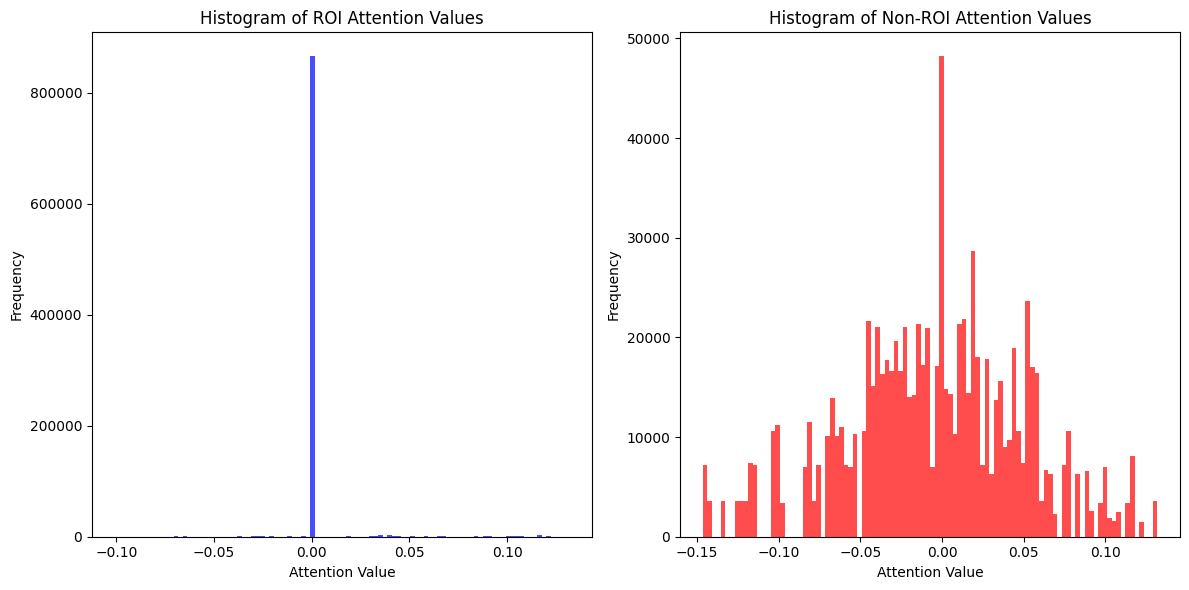

In [124]:
# create histograms of the attention values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(roi_att_values.view(-1).detach().cpu().numpy(), bins=100, alpha=0.7, color='blue', label='ROI Attention Values')
plt.title('Histogram of ROI Attention Values')
plt.xlabel('Attention Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(non_roi_att_values.view(-1).detach().cpu().numpy(), bins=100, alpha=0.7, color='red', label='Non-ROI Attention Values')
plt.title('Histogram of Non-ROI Attention Values')
plt.xlabel('Attention Value')
plt.ylabel('Frequency')
plt.tight_layout()

In [99]:
from scipy.stats import pearsonr, spearmanr # For Pearson and Spearman correlation

roi_scores = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017463235184550285, 0.005055147223174572, 0.0, 0.02366727963089943, 0.0, 0.0, 0.0185546875, 0.0029296875, 0.0029296875, 0.052978515625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013786765048280358, 0.0, 0.0, 0.01171875, 0.0004595588252414018, 0.0986328125, 0.262451171875, 0.01123046875, 0.0068359375, 0.251220703125, 0.12158203125, 0.13947610557079315, 0.5436580777168274, 0.2709099352359772, 0.2203584611415863, 0.5009191036224365, 0.23322610557079315, 0.019775390625, 0.21484375, 0.09423828125, 0.10498046875, 0.180419921875, 0.039794921875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10202205926179886, 0.0002297794126207009, 0.0002297794126207009, 0.1812959611415863, 0.008961397223174572, 0.230712890625, 0.572021484375, 0.20654296875, 0.20458984375, 0.565185546875, 0.2958984375, 0.23782169818878174, 0.4368106722831726, 0.06387867778539658, 0.06364889442920685, 0.4188878536224365, 0.3375459611415863, 0.01318359375, 0.05908203125, 0.00244140625, 0.0029296875, 0.033203125, 0.0302734375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06135110184550285, 0.14085477590560913, 0.16107536852359772, 0.03791360184550285, 0.0013786765048280358, 0.0341796875, 0.40234375, 0.352294921875, 0.40380859375, 0.265625, 0.06005859375, 0.010799632407724857, 0.10133272409439087, 0.004365808796137571, 0.0011488971067592502, 0.016773896291851997, 0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009420955553650856, 0.11741727590560913, 0.10822610557079315, 0.004136029630899429, 0.0, 0.0, 0.195556640625, 0.3671875, 0.29296875, 0.178955078125, 0.004638671875, 0.0, 0.01585477963089943, 0.0, 0.0, 0.014246323145925999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0185546875, 0.004150390625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
roi_scores = np.array(roi_scores, dtype=np.float32)

# ---------- Token-level correlation analysis ----------

pearson_correlations = []
spearmanr_correlations = []

for i in range (1, 8):
    attn_map = model.get_attention_map(layer=i, head=None, average_heads=True)
    attn_map = attn_map[:, 0, 1:]  # CLS attention vector
    softmaxed_attn_map = torch.softmax(attn_map, dim=-1).squeeze()  # Apply softmax to the CLS attention vector
    pearson_corr = pearsonr(softmaxed_attn_map.detach().cpu().numpy(), roi_scores)[0]
    pearson_correlations.append(pearson_corr)
    spearmanr_corr = spearmanr(softmaxed_attn_map.detach().cpu().numpy(), roi_scores)[0]
    spearmanr_correlations.append(spearmanr_corr)

print('Pearson Correlations:', pearson_correlations)
print('Spearman Correlations:', spearmanr_correlations)
    

Pearson Correlations: [0.39817178, 0.31769574, 0.15822315, 0.16713826, -0.07831353, 0.33660194, -0.23532745]
Spearman Correlations: [0.5438213203309505, 0.4553772138304637, 0.20101457566598194, 0.2373431312251028, 0.0376345366721395, 0.27428845187072354, -0.28026444617298796]
